20220920
Multilayer perceptron을 이용한 예측
- origin

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os

import torch
print(torch.cuda.is_available())
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0, 1, 2, 3"  # Set the GPUs 2 and 3 to use

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

import matplotlib.pyplot as plt

True
Device: cuda:1
Current cuda device: 0
Count of using GPUs: 4


In [2]:
%matplotlib inline

df = pd.read_csv('../data_up_delta.csv')
df.head()

,Unnamed: 0,receve comp time,printing start time,printing comp time,cutting start time,cutting comp time,pac time,T1,T2,T3,...,T5,X1,X2,X3,X4,Y0,X1_d1,X3_d1,X1_d2,X3_d2
0,2,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
1,3,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
2,4,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
3,5,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
4,6,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0


In [3]:
input_data = pd.DataFrame()
input_data[['receve comp time', 'X1','X2','X3', 'X4', 'X1_d1', 'X3_d1','Y0']] = df[['receve comp time', 'X1','X2','X3', 'X4', 'X1_d1', 'X3_d1', 'Y0']]
input_data.head(5)

,receve comp time,X1,X2,X3,X4,X1_d1,X3_d1,Y0
0,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,70.0,540.0
1,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,70.0,540.0
2,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,70.0,540.0
3,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,70.0,540.0
4,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,140.0,70.0,540.0


In [4]:
# 데이터 프레임.info() 함수는 데이터프레임에 관한 정보
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16992 entries, 0 to 16991
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   receve comp time  16992 non-null  object 
 1   X1                16992 non-null  float64
 2   X2                16992 non-null  float64
 3   X3                16992 non-null  float64
 4   X4                16992 non-null  float64
 5   X1_d1             16992 non-null  float64
 6   X3_d1             16992 non-null  float64
 7   Y0                16992 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.0+ MB


X1, X2, X3, X4 의 평균 구하기 추정할 때, 값이 없을 경우 평균으로 입력

In [5]:
X1_mean = df['X1'].mean()
X2_mean = df['X2'].mean()
X3_mean = df['X3'].mean()
X4_mean = df['X4'].mean()
Y0_mean = df['Y0'].mean()

X1_d1_mean = df['X1_d1'].mean()
X3_d1_mean = df['X3_d1'].mean()
print('X1 mean={:.2f}, X2 mean={:.2f}, X3 mean={:.2f}, X4 mean={:.2f}'.format(X1_mean, X2_mean, X3_mean, X4_mean))
print('X1_d1 mean={:.2f}, X3_d1 mean={:.2f}'.format(X1_d1_mean, X3_d1_mean))

X1 mean=123.99, X2 mean=5.05, X3 mean=130.89, X4 mean=10.54
X1_d1 mean=123.99, X3_d1 mean=130.89


In [6]:
# 데이터 셋을 target 기준으로 분리. Y0가 예측하려고 하는 값, X1, X2, X3 입력 변수 값
X = df[['X1','X2','X3', 'X4', 'X1_d1', 'X3_d1']].values
y = df['Y0'].values
print(X.shape, type(X))
print(y.shape, type(y))

(16992, 6) <class 'numpy.ndarray'>
(16992,) <class 'numpy.ndarray'>


In [7]:
# 80% training, 20% test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



(13593, 6) (13593,)
(3399, 6) (3399,)


데이터를 tensor 데이터형으로 변환

In [8]:
x_train_seq = torch.FloatTensor(x_train)
y_train_seq = torch.FloatTensor(y_train).view([-1, 1])
x_test_seq = torch.FloatTensor(x_test)
y_test_seq = torch.FloatTensor(y_test).view([-1, 1])
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([13593, 6]) torch.Size([13593, 1])
torch.Size([3399, 6]) torch.Size([3399, 1])


In [9]:
x_train_seq = x_train_seq.to(device)
y_train_seq = y_train_seq.to(device)
x_test_seq =  x_test_seq.to(device)
y_test_seq = y_test_seq.to(device)
print(x_train_seq.is_cuda)

True


data loader 만들기

In [10]:
# 배치 형태로 만들어 주자. 시계열이니까 셔플을 막 하면 안된다
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)  # x_train 과 y_train 은 하나의 TensorDataset 으로 결합
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  TensorDataset, DataLoader

모델 만들기

In [19]:
relu = nn.ReLU()
linear1 = nn.Linear(6, 64, bias=True)
linear2 = nn.Linear(64, 512, bias=True)
linear3 = nn.Linear(512, 1024, bias=True)
linear4 = nn.Linear(1024, 2048, bias=True)
linear5 = nn.Linear(2048, 4096, bias=True)
linear6 = nn.Linear(4096, 8192, bias=True)
linear7 = nn.Linear(8192, 2048, bias=True)
linear8 = nn.Linear(2048, 512, bias=True)
linear9 = nn.Linear(512, 32, bias=True)
linear10 = nn.Linear(32, 1, bias=True)

nn.init.xavier_uniform_(linear1.weight)
nn.init.xavier_uniform_(linear2.weight)
nn.init.xavier_uniform_(linear3.weight)
nn.init.xavier_uniform_(linear4.weight)
nn.init.xavier_uniform_(linear5.weight)
nn.init.xavier_uniform_(linear6.weight)
nn.init.xavier_uniform_(linear7.weight)
nn.init.xavier_uniform_(linear8.weight)
nn.init.xavier_uniform_(linear9.weight)
nn.init.xavier_uniform_(linear10.weight)

model = nn.Sequential(
    linear1, relu,
    linear2, relu,
    linear3, relu,
    linear4, relu,
    linear5, relu,
    linear6, relu,
    linear7, relu,
    linear8, relu,
    linear9, relu,
    linear10
)

print(model)

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2048, out_features=4096, bias=True)
  (9): ReLU()
  (10): Linear(in_features=4096, out_features=8192, bias=True)
  (11): ReLU()
  (12): Linear(in_features=8192, out_features=2048, bias=True)
  (13): ReLU()
  (14): Linear(in_features=2048, out_features=512, bias=True)
  (15): ReLU()
  (16): Linear(in_features=512, out_features=32, bias=True)
  (17): ReLU()
  (18): Linear(in_features=32, out_features=1, bias=True)
)


In [20]:
model.to(device)

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2048, out_features=4096, bias=True)
  (9): ReLU()
  (10): Linear(in_features=4096, out_features=8192, bias=True)
  (11): ReLU()
  (12): Linear(in_features=8192, out_features=2048, bias=True)
  (13): ReLU()
  (14): Linear(in_features=2048, out_features=512, bias=True)
  (15): ReLU()
  (16): Linear(in_features=512, out_features=32, bias=True)
  (17): ReLU()
  (18): Linear(in_features=32, out_features=1, bias=True)
)

In [21]:
import time
import os
import datetime
import os
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


num_epochs = 5000
batch_size = 50
learning_r = 1e-3
pwd = os.getcwd()
print(pwd)
model_name = os.path.join(pwd,'model/mlp-data_up_delta3.model')
figure_name = os.path.join(pwd,'result/mlp-data_up_delta3.png')
print(model_name, figure_name)

def training(model, train_dataloader):
    print("\nTraining is Started ")
    model.train()
    criterion = nn.MSELoss()       
    optimizer = optim.Adam(model.parameters(), lr=learning_r)  

    start_time = time.time()
    loss_graph = [] # 그래프 그릴 목적인 loss.
    n = len(train_loader)

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.
        for data in train_loader:
            seq, target = data
            out = model(seq) 
            loss = criterion(out, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss_graph.append(running_loss / n)
        if epoch % 10 == 0:
            print('[epoch: {}] loss: {:.4f}   Time: {}'.format(epoch, running_loss/n, datetime.datetime.now()))
    plt.figure(figsize=(20,10))
    plt.plot(loss_graph)
    plt.show()
    plt.savefig(figure_name)

    torch.save(model.state_dict(), model_name)
    print('    model_path={} is saved'.format(model_name))
    return


/sharehouse/DATA/SMART_FACTORY/ckim
/sharehouse/DATA/SMART_FACTORY/ckim/model/mlp-data_up_delta3.model /sharehouse/DATA/SMART_FACTORY/ckim/result/mlp-data_up_delta3.png


In [22]:
# err_range = 10.  # error range in hit ratio
def testing(model, test_loader, err_range): # all values / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data in test_loader:
          seq, target = data
          out = model(seq)
          test_pred += out.cpu().numpy().tolist()
          test_actual += target.cpu().numpy().tolist()
    print(len(test_pred), len(test_actual))
    print(test_pred[10:20])
    print(test_actual[10:20])
    
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

In [23]:
def testing2(model, test_loader, x2, x3, x4, x1_d1, x3_d1, err_range): # X1, All mean values / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data in test_loader:
          seq, target = data
          seq[:,1] = x2
          seq[:,2] = x3
          seq[:,3] = x4
          seq[:,4] = x1_d1
          seq[:,5] = x3_d1
          out = model(seq)
          test_pred += out.cpu().numpy().tolist()
          test_actual += target.cpu().numpy().tolist()
    print(len(test_pred), len(test_actual))
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

In [24]:
def testing3(model, test_loader, x2, x3, x4, x1_d1, x3_d1, err_range): # X1, X2 mean, X3 previous value, X4 mean / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data in test_loader:
          seq, target = data
        
          #print(seq)
          seq[:,1] = x2
          seq[:,2] = seq[:, 1]
          seq[:,3] = x4
          #print('---> ', seq)
        
          out = model(seq)
          test_pred += out.cpu().numpy().tolist()
          test_actual += target.cpu().numpy().tolist()
    print(len(test_pred), len(test_actual))
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

  0%|          | 0/5000 [00:00<?, ?it/s]


Training is Started 


  0%|          | 1/5000 [00:04<5:43:47,  4.13s/it]

[epoch: 0] loss: 51424.9585   Time: 2022-09-20 18:12:53.682667


  0%|          | 11/5000 [00:45<5:41:35,  4.11s/it]

[epoch: 10] loss: 4078.1526   Time: 2022-09-20 18:13:34.821458


  0%|          | 21/5000 [01:26<5:41:13,  4.11s/it]

[epoch: 20] loss: 1318.3992   Time: 2022-09-20 18:14:15.895965


  1%|          | 31/5000 [02:07<5:40:02,  4.11s/it]

[epoch: 30] loss: 270.0301   Time: 2022-09-20 18:14:56.953011


  1%|          | 41/5000 [02:48<5:39:49,  4.11s/it]

[epoch: 40] loss: 76365.4054   Time: 2022-09-20 18:15:38.061906


  1%|          | 51/5000 [03:29<5:40:43,  4.13s/it]

[epoch: 50] loss: 81.9585   Time: 2022-09-20 18:16:19.312987


  1%|          | 61/5000 [04:11<5:40:05,  4.13s/it]

[epoch: 60] loss: 704.9439   Time: 2022-09-20 18:17:00.631489


  1%|▏         | 71/5000 [04:52<5:39:22,  4.13s/it]

[epoch: 70] loss: 29.0024   Time: 2022-09-20 18:17:41.951387


  2%|▏         | 81/5000 [05:33<5:38:42,  4.13s/it]

[epoch: 80] loss: 8.5924   Time: 2022-09-20 18:18:23.262877


  2%|▏         | 91/5000 [06:15<5:38:05,  4.13s/it]

[epoch: 90] loss: 48.6882   Time: 2022-09-20 18:19:04.580804


  2%|▏         | 101/5000 [06:56<5:37:12,  4.13s/it]

[epoch: 100] loss: 5.9427   Time: 2022-09-20 18:19:45.882523


  2%|▏         | 111/5000 [07:37<5:36:45,  4.13s/it]

[epoch: 110] loss: 23.4293   Time: 2022-09-20 18:20:27.212708


  2%|▏         | 121/5000 [08:18<5:36:07,  4.13s/it]

[epoch: 120] loss: 7.8325   Time: 2022-09-20 18:21:08.552079


  3%|▎         | 131/5000 [09:00<5:35:12,  4.13s/it]

[epoch: 130] loss: 1234.7517   Time: 2022-09-20 18:21:49.855853


  3%|▎         | 141/5000 [09:41<5:34:15,  4.13s/it]

[epoch: 140] loss: 205.1487   Time: 2022-09-20 18:22:31.144894


  3%|▎         | 151/5000 [10:22<5:33:40,  4.13s/it]

[epoch: 150] loss: 7.1485   Time: 2022-09-20 18:23:12.409164


  3%|▎         | 161/5000 [11:04<5:32:51,  4.13s/it]

[epoch: 160] loss: 8.6487   Time: 2022-09-20 18:23:53.692702


  3%|▎         | 171/5000 [11:45<5:30:41,  4.11s/it]

[epoch: 170] loss: 21.6891   Time: 2022-09-20 18:24:34.786226


  4%|▎         | 181/5000 [12:26<5:29:39,  4.10s/it]

[epoch: 180] loss: 390.9123   Time: 2022-09-20 18:25:15.833506


  4%|▍         | 191/5000 [13:06<5:22:38,  4.03s/it]

[epoch: 190] loss: 447.5099   Time: 2022-09-20 18:25:56.378910


  4%|▍         | 201/5000 [13:46<5:20:58,  4.01s/it]

[epoch: 200] loss: 233.5439   Time: 2022-09-20 18:26:36.502950


  4%|▍         | 211/5000 [14:27<5:27:07,  4.10s/it]

[epoch: 210] loss: 762.7415   Time: 2022-09-20 18:27:17.436138


  4%|▍         | 221/5000 [15:08<5:27:00,  4.11s/it]

[epoch: 220] loss: 7.1802   Time: 2022-09-20 18:27:58.481642


  5%|▍         | 231/5000 [15:49<5:26:15,  4.10s/it]

[epoch: 230] loss: 2.5816   Time: 2022-09-20 18:28:39.533264


  5%|▍         | 241/5000 [16:31<5:25:42,  4.11s/it]

[epoch: 240] loss: 415.4765   Time: 2022-09-20 18:29:20.591544


  5%|▌         | 251/5000 [17:12<5:25:02,  4.11s/it]

[epoch: 250] loss: 3.7309   Time: 2022-09-20 18:30:01.653939


  5%|▌         | 261/5000 [17:53<5:24:30,  4.11s/it]

[epoch: 260] loss: 3.9456   Time: 2022-09-20 18:30:42.736057


  5%|▌         | 271/5000 [18:34<5:23:32,  4.11s/it]

[epoch: 270] loss: 1.9199   Time: 2022-09-20 18:31:23.794314


  6%|▌         | 281/5000 [19:15<5:22:52,  4.11s/it]

[epoch: 280] loss: 4.4827   Time: 2022-09-20 18:32:04.852409


  6%|▌         | 291/5000 [19:56<5:22:07,  4.10s/it]

[epoch: 290] loss: 661.5187   Time: 2022-09-20 18:32:45.894045


  6%|▌         | 301/5000 [20:37<5:21:13,  4.10s/it]

[epoch: 300] loss: 253.9230   Time: 2022-09-20 18:33:26.915630


  6%|▌         | 311/5000 [21:18<5:20:36,  4.10s/it]

[epoch: 310] loss: 205.3914   Time: 2022-09-20 18:34:07.935240


  6%|▋         | 321/5000 [21:59<5:19:50,  4.10s/it]

[epoch: 320] loss: 636.5093   Time: 2022-09-20 18:34:48.947871


  7%|▋         | 331/5000 [22:40<5:19:13,  4.10s/it]

[epoch: 330] loss: 4.1986   Time: 2022-09-20 18:35:29.976418


  7%|▋         | 341/5000 [23:21<5:18:36,  4.10s/it]

[epoch: 340] loss: 20.9498   Time: 2022-09-20 18:36:11.022626


  7%|▋         | 351/5000 [24:02<5:17:54,  4.10s/it]

[epoch: 350] loss: 244.1502   Time: 2022-09-20 18:36:52.050460


  7%|▋         | 361/5000 [24:43<5:20:49,  4.15s/it]

[epoch: 360] loss: 823.0945   Time: 2022-09-20 18:37:33.305566


  7%|▋         | 371/5000 [25:25<5:24:21,  4.20s/it]

[epoch: 370] loss: 10.2954   Time: 2022-09-20 18:38:15.217537


  8%|▊         | 381/5000 [26:06<5:16:42,  4.11s/it]

[epoch: 380] loss: 30.6008   Time: 2022-09-20 18:38:56.534150


  8%|▊         | 391/5000 [26:48<5:15:24,  4.11s/it]

[epoch: 390] loss: 39.7111   Time: 2022-09-20 18:39:37.604617


  8%|▊         | 401/5000 [27:29<5:14:55,  4.11s/it]

[epoch: 400] loss: 2.5359   Time: 2022-09-20 18:40:18.689105


  8%|▊         | 411/5000 [28:10<5:14:03,  4.11s/it]

[epoch: 410] loss: 3.2330   Time: 2022-09-20 18:40:59.744969


  8%|▊         | 421/5000 [28:51<5:13:20,  4.11s/it]

[epoch: 420] loss: 1.6262   Time: 2022-09-20 18:41:40.804381


  9%|▊         | 431/5000 [29:32<5:12:38,  4.11s/it]

[epoch: 430] loss: 2.0169   Time: 2022-09-20 18:42:21.861052


  9%|▉         | 441/5000 [30:13<5:11:55,  4.11s/it]

[epoch: 440] loss: 172.5338   Time: 2022-09-20 18:43:02.915686


  9%|▉         | 451/5000 [30:54<5:11:04,  4.10s/it]

[epoch: 450] loss: 30.1791   Time: 2022-09-20 18:43:43.953409


  9%|▉         | 461/5000 [31:35<5:10:21,  4.10s/it]

[epoch: 460] loss: 635.8918   Time: 2022-09-20 18:44:24.972790


  9%|▉         | 471/5000 [32:16<5:09:38,  4.10s/it]

[epoch: 470] loss: 337.2143   Time: 2022-09-20 18:45:05.994155


 10%|▉         | 481/5000 [32:57<5:09:02,  4.10s/it]

[epoch: 480] loss: 3.9065   Time: 2022-09-20 18:45:47.022867


 10%|▉         | 491/5000 [33:38<5:08:11,  4.10s/it]

[epoch: 490] loss: 1.7341   Time: 2022-09-20 18:46:28.037322


 10%|█         | 501/5000 [34:19<5:07:48,  4.11s/it]

[epoch: 500] loss: 13.2144   Time: 2022-09-20 18:47:09.061635


 10%|█         | 511/5000 [35:00<5:06:40,  4.10s/it]

[epoch: 510] loss: 2.3800   Time: 2022-09-20 18:47:50.052480


 10%|█         | 521/5000 [35:41<5:05:56,  4.10s/it]

[epoch: 520] loss: 1.8270   Time: 2022-09-20 18:48:31.041205


 11%|█         | 531/5000 [36:22<5:05:22,  4.10s/it]

[epoch: 530] loss: 1.4728   Time: 2022-09-20 18:49:12.037318


 11%|█         | 541/5000 [37:03<5:04:38,  4.10s/it]

[epoch: 540] loss: 8.3237   Time: 2022-09-20 18:49:53.028405


 11%|█         | 551/5000 [37:44<5:03:54,  4.10s/it]

[epoch: 550] loss: 20.8110   Time: 2022-09-20 18:50:34.016240


 11%|█         | 561/5000 [38:25<5:03:12,  4.10s/it]

[epoch: 560] loss: 161.4775   Time: 2022-09-20 18:51:15.004048


 11%|█▏        | 571/5000 [39:06<5:02:34,  4.10s/it]

[epoch: 570] loss: 1.1928   Time: 2022-09-20 18:51:55.991264


 12%|█▏        | 581/5000 [39:47<5:02:56,  4.11s/it]

[epoch: 580] loss: 100.5711   Time: 2022-09-20 18:52:37.109586


 12%|█▏        | 591/5000 [40:28<5:01:14,  4.10s/it]

[epoch: 590] loss: 131.1509   Time: 2022-09-20 18:53:18.104723


 12%|█▏        | 601/5000 [41:09<5:00:25,  4.10s/it]

[epoch: 600] loss: 6.1266   Time: 2022-09-20 18:53:59.087214


 12%|█▏        | 611/5000 [41:50<4:59:44,  4.10s/it]

[epoch: 610] loss: 2.1601   Time: 2022-09-20 18:54:40.063065


 12%|█▏        | 621/5000 [42:31<4:59:38,  4.11s/it]

[epoch: 620] loss: 178.7682   Time: 2022-09-20 18:55:21.067538


 13%|█▎        | 631/5000 [43:12<4:58:24,  4.10s/it]

[epoch: 630] loss: 2.8553   Time: 2022-09-20 18:56:02.048547


 13%|█▎        | 641/5000 [43:53<4:57:43,  4.10s/it]

[epoch: 640] loss: 3.6269   Time: 2022-09-20 18:56:43.032818


 13%|█▎        | 651/5000 [44:34<4:57:05,  4.10s/it]

[epoch: 650] loss: 2.5368   Time: 2022-09-20 18:57:24.019777


 13%|█▎        | 661/5000 [45:15<4:57:14,  4.11s/it]

[epoch: 660] loss: 1.9157   Time: 2022-09-20 18:58:05.153873


 13%|█▎        | 671/5000 [45:56<4:56:37,  4.11s/it]

[epoch: 670] loss: 81.2327   Time: 2022-09-20 18:58:46.203005


 14%|█▎        | 681/5000 [46:37<4:55:09,  4.10s/it]

[epoch: 680] loss: 1.2987   Time: 2022-09-20 18:59:27.208528


 14%|█▍        | 691/5000 [47:18<4:54:34,  4.10s/it]

[epoch: 690] loss: 114.3198   Time: 2022-09-20 19:00:08.211528


 14%|█▍        | 701/5000 [47:59<4:53:48,  4.10s/it]

[epoch: 700] loss: 2.3325   Time: 2022-09-20 19:00:49.212867


 14%|█▍        | 711/5000 [48:40<4:53:03,  4.10s/it]

[epoch: 710] loss: 2.8699   Time: 2022-09-20 19:01:30.205312


 14%|█▍        | 721/5000 [49:21<4:52:21,  4.10s/it]

[epoch: 720] loss: 2.5221   Time: 2022-09-20 19:02:11.199823


 15%|█▍        | 731/5000 [50:02<4:51:52,  4.10s/it]

[epoch: 730] loss: 7.9285   Time: 2022-09-20 19:02:52.205005


 15%|█▍        | 741/5000 [50:43<4:51:13,  4.10s/it]

[epoch: 740] loss: 1.3357   Time: 2022-09-20 19:03:33.228077


 15%|█▌        | 751/5000 [51:24<4:50:33,  4.10s/it]

[epoch: 750] loss: 69.6954   Time: 2022-09-20 19:04:14.248275


 15%|█▌        | 761/5000 [52:05<4:49:46,  4.10s/it]

[epoch: 760] loss: 1.9845   Time: 2022-09-20 19:04:55.264696


 15%|█▌        | 771/5000 [52:46<4:49:01,  4.10s/it]

[epoch: 770] loss: 1.2156   Time: 2022-09-20 19:05:36.284496


 16%|█▌        | 781/5000 [53:27<4:48:16,  4.10s/it]

[epoch: 780] loss: 2.8226   Time: 2022-09-20 19:06:17.279245


 16%|█▌        | 791/5000 [54:08<4:47:28,  4.10s/it]

[epoch: 790] loss: 2.9256   Time: 2022-09-20 19:06:58.266834


 16%|█▌        | 801/5000 [54:49<4:46:52,  4.10s/it]

[epoch: 800] loss: 1.2338   Time: 2022-09-20 19:07:39.262200


 16%|█▌        | 811/5000 [55:30<4:46:04,  4.10s/it]

[epoch: 810] loss: 7.7799   Time: 2022-09-20 19:08:20.237810


 16%|█▋        | 821/5000 [56:11<4:45:29,  4.10s/it]

[epoch: 820] loss: 3.6168   Time: 2022-09-20 19:09:01.221506


 17%|█▋        | 831/5000 [56:52<4:45:00,  4.10s/it]

[epoch: 830] loss: 56.1303   Time: 2022-09-20 19:09:42.278560


 17%|█▋        | 841/5000 [57:33<4:45:09,  4.11s/it]

[epoch: 840] loss: 62.7101   Time: 2022-09-20 19:10:23.333451


 17%|█▋        | 851/5000 [58:14<4:43:52,  4.11s/it]

[epoch: 850] loss: 1.1448   Time: 2022-09-20 19:11:04.417454


 17%|█▋        | 861/5000 [58:55<4:43:01,  4.10s/it]

[epoch: 860] loss: 13.1441   Time: 2022-09-20 19:11:45.445655


 17%|█▋        | 871/5000 [59:36<4:42:17,  4.10s/it]

[epoch: 870] loss: 4.6760   Time: 2022-09-20 19:12:26.463133


 18%|█▊        | 881/5000 [1:00:17<4:41:32,  4.10s/it]

[epoch: 880] loss: 8.3232   Time: 2022-09-20 19:13:07.479699


 18%|█▊        | 891/5000 [1:00:58<4:40:50,  4.10s/it]

[epoch: 890] loss: 1.2096   Time: 2022-09-20 19:13:48.491271


 18%|█▊        | 901/5000 [1:01:39<4:40:15,  4.10s/it]

[epoch: 900] loss: 1.5084   Time: 2022-09-20 19:14:29.525108


 18%|█▊        | 911/5000 [1:02:20<4:39:29,  4.10s/it]

[epoch: 910] loss: 1.2215   Time: 2022-09-20 19:15:10.537687


 18%|█▊        | 921/5000 [1:03:02<4:38:40,  4.10s/it]

[epoch: 920] loss: 164.9843   Time: 2022-09-20 19:15:51.579142


 19%|█▊        | 931/5000 [1:03:43<4:37:56,  4.10s/it]

[epoch: 930] loss: 1.9803   Time: 2022-09-20 19:16:32.568677


 19%|█▉        | 941/5000 [1:04:23<4:37:17,  4.10s/it]

[epoch: 940] loss: 53.9701   Time: 2022-09-20 19:17:13.554569


 19%|█▉        | 951/5000 [1:05:04<4:36:36,  4.10s/it]

[epoch: 950] loss: 1.1654   Time: 2022-09-20 19:17:54.552362


 19%|█▉        | 961/5000 [1:05:45<4:35:55,  4.10s/it]

[epoch: 960] loss: 55.8173   Time: 2022-09-20 19:18:35.545776


 19%|█▉        | 971/5000 [1:06:26<4:35:24,  4.10s/it]

[epoch: 970] loss: 85.4822   Time: 2022-09-20 19:19:16.554084


 20%|█▉        | 981/5000 [1:07:08<4:34:41,  4.10s/it]

[epoch: 980] loss: 104.0195   Time: 2022-09-20 19:19:57.561551


 20%|█▉        | 991/5000 [1:07:49<4:34:30,  4.11s/it]

[epoch: 990] loss: 1.9771   Time: 2022-09-20 19:20:38.645052


 20%|██        | 1001/5000 [1:08:30<4:33:25,  4.10s/it]

[epoch: 1000] loss: 1.2562   Time: 2022-09-20 19:21:19.659855


 20%|██        | 1011/5000 [1:09:11<4:33:04,  4.11s/it]

[epoch: 1010] loss: 1.4803   Time: 2022-09-20 19:22:00.735054


 20%|██        | 1021/5000 [1:09:52<4:32:03,  4.10s/it]

[epoch: 1020] loss: 3.6038   Time: 2022-09-20 19:22:41.760519


 21%|██        | 1031/5000 [1:10:33<4:31:15,  4.10s/it]

[epoch: 1030] loss: 4.3040   Time: 2022-09-20 19:23:22.769562


 21%|██        | 1041/5000 [1:11:14<4:30:38,  4.10s/it]

[epoch: 1040] loss: 1.1614   Time: 2022-09-20 19:24:03.865868


 21%|██        | 1051/5000 [1:11:55<4:30:02,  4.10s/it]

[epoch: 1050] loss: 2.8529   Time: 2022-09-20 19:24:44.884862


 21%|██        | 1061/5000 [1:12:36<4:29:11,  4.10s/it]

[epoch: 1060] loss: 1.4543   Time: 2022-09-20 19:25:25.886969


 21%|██▏       | 1071/5000 [1:13:17<4:29:23,  4.11s/it]

[epoch: 1070] loss: 1.2947   Time: 2022-09-20 19:26:07.127275


 22%|██▏       | 1081/5000 [1:13:58<4:28:08,  4.11s/it]

[epoch: 1080] loss: 6.0811   Time: 2022-09-20 19:26:48.190803


 22%|██▏       | 1091/5000 [1:14:39<4:27:50,  4.11s/it]

[epoch: 1090] loss: 9.8862   Time: 2022-09-20 19:27:29.254312


 22%|██▏       | 1101/5000 [1:15:20<4:27:02,  4.11s/it]

[epoch: 1100] loss: 232.9661   Time: 2022-09-20 19:28:10.335619


 22%|██▏       | 1111/5000 [1:16:01<4:26:00,  4.10s/it]

[epoch: 1110] loss: 4.9725   Time: 2022-09-20 19:28:51.356929


 22%|██▏       | 1121/5000 [1:16:42<4:25:14,  4.10s/it]

[epoch: 1120] loss: 1.1562   Time: 2022-09-20 19:29:32.387807


 23%|██▎       | 1131/5000 [1:17:23<4:24:28,  4.10s/it]

[epoch: 1130] loss: 52.5600   Time: 2022-09-20 19:30:13.400470


 23%|██▎       | 1141/5000 [1:18:04<4:23:47,  4.10s/it]

[epoch: 1140] loss: 164.8391   Time: 2022-09-20 19:30:54.415957


 23%|██▎       | 1151/5000 [1:18:45<4:23:02,  4.10s/it]

[epoch: 1150] loss: 2.6627   Time: 2022-09-20 19:31:35.423991


 23%|██▎       | 1161/5000 [1:19:26<4:22:26,  4.10s/it]

[epoch: 1160] loss: 302.9795   Time: 2022-09-20 19:32:16.435690


 23%|██▎       | 1171/5000 [1:20:07<4:23:47,  4.13s/it]

[epoch: 1170] loss: 1.2758   Time: 2022-09-20 19:32:57.556191


 24%|██▎       | 1181/5000 [1:20:49<4:21:05,  4.10s/it]

[epoch: 1180] loss: 239.5814   Time: 2022-09-20 19:33:38.563226


 24%|██▍       | 1191/5000 [1:21:30<4:20:16,  4.10s/it]

[epoch: 1190] loss: 1.2815   Time: 2022-09-20 19:34:19.558725


 24%|██▍       | 1201/5000 [1:22:11<4:19:59,  4.11s/it]

[epoch: 1200] loss: 73.4954   Time: 2022-09-20 19:35:00.620887


 24%|██▍       | 1211/5000 [1:22:52<4:19:00,  4.10s/it]

[epoch: 1210] loss: 1.2258   Time: 2022-09-20 19:35:41.633333


 24%|██▍       | 1221/5000 [1:23:33<4:18:19,  4.10s/it]

[epoch: 1220] loss: 85.0634   Time: 2022-09-20 19:36:22.654335


 25%|██▍       | 1231/5000 [1:24:14<4:17:33,  4.10s/it]

[epoch: 1230] loss: 11.0744   Time: 2022-09-20 19:37:03.656180


 25%|██▍       | 1241/5000 [1:24:55<4:16:53,  4.10s/it]

[epoch: 1240] loss: 1.6804   Time: 2022-09-20 19:37:44.665704


 25%|██▌       | 1251/5000 [1:25:36<4:16:14,  4.10s/it]

[epoch: 1250] loss: 75.3009   Time: 2022-09-20 19:38:25.676729


 25%|██▌       | 1261/5000 [1:26:17<4:15:35,  4.10s/it]

[epoch: 1260] loss: 512.9563   Time: 2022-09-20 19:39:06.686393


 25%|██▌       | 1271/5000 [1:26:58<4:14:52,  4.10s/it]

[epoch: 1270] loss: 58.0906   Time: 2022-09-20 19:39:47.690972


 26%|██▌       | 1281/5000 [1:27:39<4:14:10,  4.10s/it]

[epoch: 1280] loss: 1.3086   Time: 2022-09-20 19:40:28.700276


 26%|██▌       | 1291/5000 [1:28:20<4:13:35,  4.10s/it]

[epoch: 1290] loss: 16.5337   Time: 2022-09-20 19:41:09.724916


 26%|██▌       | 1301/5000 [1:29:01<4:12:56,  4.10s/it]

[epoch: 1300] loss: 343.4213   Time: 2022-09-20 19:41:50.743176


 26%|██▌       | 1311/5000 [1:29:42<4:12:07,  4.10s/it]

[epoch: 1310] loss: 88.6741   Time: 2022-09-20 19:42:31.753223


 26%|██▋       | 1321/5000 [1:30:23<4:11:36,  4.10s/it]

[epoch: 1320] loss: 1.6616   Time: 2022-09-20 19:43:12.771887


 27%|██▋       | 1331/5000 [1:31:04<4:10:42,  4.10s/it]

[epoch: 1330] loss: 11.3996   Time: 2022-09-20 19:43:53.768129


 27%|██▋       | 1341/5000 [1:31:45<4:10:01,  4.10s/it]

[epoch: 1340] loss: 42.8297   Time: 2022-09-20 19:44:34.769420


 27%|██▋       | 1351/5000 [1:32:26<4:09:15,  4.10s/it]

[epoch: 1350] loss: 1.3785   Time: 2022-09-20 19:45:15.756765


 27%|██▋       | 1361/5000 [1:33:07<4:08:39,  4.10s/it]

[epoch: 1360] loss: 2.3982   Time: 2022-09-20 19:45:56.756188


 27%|██▋       | 1371/5000 [1:33:48<4:07:52,  4.10s/it]

[epoch: 1370] loss: 276.6538   Time: 2022-09-20 19:46:37.737064


 28%|██▊       | 1381/5000 [1:34:29<4:07:10,  4.10s/it]

[epoch: 1380] loss: 1.1518   Time: 2022-09-20 19:47:18.717053


 28%|██▊       | 1391/5000 [1:35:10<4:06:34,  4.10s/it]

[epoch: 1390] loss: 2.4754   Time: 2022-09-20 19:47:59.712826


 28%|██▊       | 1401/5000 [1:35:51<4:05:51,  4.10s/it]

[epoch: 1400] loss: 134.1344   Time: 2022-09-20 19:48:40.703376


 28%|██▊       | 1411/5000 [1:36:32<4:05:12,  4.10s/it]

[epoch: 1410] loss: 2.4606   Time: 2022-09-20 19:49:21.692330


 28%|██▊       | 1421/5000 [1:37:13<4:04:27,  4.10s/it]

[epoch: 1420] loss: 1.2003   Time: 2022-09-20 19:50:02.676940


 29%|██▊       | 1431/5000 [1:37:54<4:03:50,  4.10s/it]

[epoch: 1430] loss: 1.9036   Time: 2022-09-20 19:50:43.670985


 29%|██▉       | 1441/5000 [1:38:35<4:03:06,  4.10s/it]

[epoch: 1440] loss: 2.3496   Time: 2022-09-20 19:51:24.657573


 29%|██▉       | 1451/5000 [1:39:16<4:02:37,  4.10s/it]

[epoch: 1450] loss: 8.1266   Time: 2022-09-20 19:52:05.655279


 29%|██▉       | 1461/5000 [1:39:57<4:01:52,  4.10s/it]

[epoch: 1460] loss: 3.1814   Time: 2022-09-20 19:52:46.662441


 29%|██▉       | 1471/5000 [1:40:38<4:01:10,  4.10s/it]

[epoch: 1470] loss: 70.6798   Time: 2022-09-20 19:53:27.670799


 30%|██▉       | 1481/5000 [1:41:19<4:01:02,  4.11s/it]

[epoch: 1480] loss: 1.2659   Time: 2022-09-20 19:54:08.745185


 30%|██▉       | 1491/5000 [1:42:00<3:59:46,  4.10s/it]

[epoch: 1490] loss: 2.6574   Time: 2022-09-20 19:54:49.743242


 30%|███       | 1501/5000 [1:42:41<3:58:59,  4.10s/it]

[epoch: 1500] loss: 136.6795   Time: 2022-09-20 19:55:30.725488


 30%|███       | 1511/5000 [1:43:22<3:58:20,  4.10s/it]

[epoch: 1510] loss: 26.3242   Time: 2022-09-20 19:56:11.707573


 30%|███       | 1521/5000 [1:44:03<3:57:37,  4.10s/it]

[epoch: 1520] loss: 1.1455   Time: 2022-09-20 19:56:52.684477


 31%|███       | 1531/5000 [1:44:44<3:56:54,  4.10s/it]

[epoch: 1530] loss: 1.8065   Time: 2022-09-20 19:57:33.663603


 31%|███       | 1541/5000 [1:45:25<3:56:30,  4.10s/it]

[epoch: 1540] loss: 5.3963   Time: 2022-09-20 19:58:14.679483


 31%|███       | 1551/5000 [1:46:06<3:55:48,  4.10s/it]

[epoch: 1550] loss: 50.9461   Time: 2022-09-20 19:58:55.703625


 31%|███       | 1561/5000 [1:46:47<3:55:03,  4.10s/it]

[epoch: 1560] loss: 1.7683   Time: 2022-09-20 19:59:36.716458


 31%|███▏      | 1571/5000 [1:47:28<3:54:30,  4.10s/it]

[epoch: 1570] loss: 13.2174   Time: 2022-09-20 20:00:17.743161


 32%|███▏      | 1581/5000 [1:48:09<3:53:35,  4.10s/it]

[epoch: 1580] loss: 5.4460   Time: 2022-09-20 20:00:58.737167


 32%|███▏      | 1591/5000 [1:48:50<3:52:56,  4.10s/it]

[epoch: 1590] loss: 64.5556   Time: 2022-09-20 20:01:39.730844


 32%|███▏      | 1601/5000 [1:49:31<3:52:14,  4.10s/it]

[epoch: 1600] loss: 2.2253   Time: 2022-09-20 20:02:20.728362


 32%|███▏      | 1611/5000 [1:50:12<3:51:32,  4.10s/it]

[epoch: 1610] loss: 2.4244   Time: 2022-09-20 20:03:01.723580


 32%|███▏      | 1621/5000 [1:50:53<3:51:03,  4.10s/it]

[epoch: 1620] loss: 10.3269   Time: 2022-09-20 20:03:42.762359


 33%|███▎      | 1631/5000 [1:51:34<3:50:04,  4.10s/it]

[epoch: 1630] loss: 1.3439   Time: 2022-09-20 20:04:23.759214


 33%|███▎      | 1641/5000 [1:52:15<3:49:28,  4.10s/it]

[epoch: 1640] loss: 2.4108   Time: 2022-09-20 20:05:04.763066


 33%|███▎      | 1651/5000 [1:52:56<3:46:17,  4.05s/it]

[epoch: 1650] loss: 65.2532   Time: 2022-09-20 20:05:45.598691


 33%|███▎      | 1661/5000 [1:53:36<3:47:34,  4.09s/it]

[epoch: 1660] loss: 1.6726   Time: 2022-09-20 20:06:26.137321


 33%|███▎      | 1671/5000 [1:54:17<3:47:48,  4.11s/it]

[epoch: 1670] loss: 2.6632   Time: 2022-09-20 20:07:07.195859


 34%|███▎      | 1681/5000 [1:54:58<3:47:30,  4.11s/it]

[epoch: 1680] loss: 1.2605   Time: 2022-09-20 20:07:48.280406


 34%|███▍      | 1691/5000 [1:55:39<3:46:48,  4.11s/it]

[epoch: 1690] loss: 2.2800   Time: 2022-09-20 20:08:29.405284


 34%|███▍      | 1701/5000 [1:56:21<3:47:34,  4.14s/it]

[epoch: 1700] loss: 59.2715   Time: 2022-09-20 20:09:10.613246


 34%|███▍      | 1711/5000 [1:57:02<3:44:53,  4.10s/it]

[epoch: 1710] loss: 1.5385   Time: 2022-09-20 20:09:51.630965


 34%|███▍      | 1721/5000 [1:57:43<3:44:17,  4.10s/it]

[epoch: 1720] loss: 39.8393   Time: 2022-09-20 20:10:32.762944


 35%|███▍      | 1731/5000 [1:58:24<3:43:32,  4.10s/it]

[epoch: 1730] loss: 2.7838   Time: 2022-09-20 20:11:13.797440


 35%|███▍      | 1741/5000 [1:59:05<3:42:49,  4.10s/it]

[epoch: 1740] loss: 29.7700   Time: 2022-09-20 20:11:54.816234


 35%|███▌      | 1751/5000 [1:59:46<3:42:06,  4.10s/it]

[epoch: 1750] loss: 91.8881   Time: 2022-09-20 20:12:35.836767


 35%|███▌      | 1761/5000 [2:00:27<3:41:18,  4.10s/it]

[epoch: 1760] loss: 29.5225   Time: 2022-09-20 20:13:16.831563


 35%|███▌      | 1771/5000 [2:01:08<3:40:39,  4.10s/it]

[epoch: 1770] loss: 31.0322   Time: 2022-09-20 20:13:57.829084


 36%|███▌      | 1781/5000 [2:01:49<3:39:59,  4.10s/it]

[epoch: 1780] loss: 3.1748   Time: 2022-09-20 20:14:38.830579


 36%|███▌      | 1791/5000 [2:02:30<3:39:27,  4.10s/it]

[epoch: 1790] loss: 47.8303   Time: 2022-09-20 20:15:19.857909


 36%|███▌      | 1801/5000 [2:03:11<3:38:47,  4.10s/it]

[epoch: 1800] loss: 43.3145   Time: 2022-09-20 20:16:00.901214


 36%|███▌      | 1811/5000 [2:03:52<3:38:08,  4.10s/it]

[epoch: 1810] loss: 3.7418   Time: 2022-09-20 20:16:41.938339


 36%|███▋      | 1821/5000 [2:04:33<3:37:30,  4.11s/it]

[epoch: 1820] loss: 81.6569   Time: 2022-09-20 20:17:22.986376


 37%|███▋      | 1831/5000 [2:05:14<3:36:48,  4.11s/it]

[epoch: 1830] loss: 54.8072   Time: 2022-09-20 20:18:04.039568


 37%|███▋      | 1841/5000 [2:05:55<3:35:40,  4.10s/it]

[epoch: 1840] loss: 1.9765   Time: 2022-09-20 20:18:44.980132


 37%|███▋      | 1851/5000 [2:06:36<3:35:35,  4.11s/it]

[epoch: 1850] loss: 1.1772   Time: 2022-09-20 20:19:26.021756


 37%|███▋      | 1861/5000 [2:07:17<3:34:29,  4.10s/it]

[epoch: 1860] loss: 1.3749   Time: 2022-09-20 20:20:07.008937


 37%|███▋      | 1871/5000 [2:07:58<3:33:36,  4.10s/it]

[epoch: 1870] loss: 3.5664   Time: 2022-09-20 20:20:47.995380


 38%|███▊      | 1881/5000 [2:08:39<3:33:16,  4.10s/it]

[epoch: 1880] loss: 2.5620   Time: 2022-09-20 20:21:29.009666


 38%|███▊      | 1891/5000 [2:09:20<3:32:37,  4.10s/it]

[epoch: 1890] loss: 2.9227   Time: 2022-09-20 20:22:10.042167


 38%|███▊      | 1901/5000 [2:10:01<3:31:53,  4.10s/it]

[epoch: 1900] loss: 2.0958   Time: 2022-09-20 20:22:51.067122


 38%|███▊      | 1911/5000 [2:10:42<3:31:09,  4.10s/it]

[epoch: 1910] loss: 2.6121   Time: 2022-09-20 20:23:32.083013


 38%|███▊      | 1921/5000 [2:11:23<3:30:38,  4.10s/it]

[epoch: 1920] loss: 1.5875   Time: 2022-09-20 20:24:13.128420


 39%|███▊      | 1931/5000 [2:12:04<3:29:49,  4.10s/it]

[epoch: 1930] loss: 2.2492   Time: 2022-09-20 20:24:54.144003


 39%|███▉      | 1941/5000 [2:12:45<3:29:23,  4.11s/it]

[epoch: 1940] loss: 39.5017   Time: 2022-09-20 20:25:35.214035


 39%|███▉      | 1951/5000 [2:13:26<3:28:25,  4.10s/it]

[epoch: 1950] loss: 50.2572   Time: 2022-09-20 20:26:16.237091


 39%|███▉      | 1961/5000 [2:14:07<3:28:00,  4.11s/it]

[epoch: 1960] loss: 1.1458   Time: 2022-09-20 20:26:57.289356


 39%|███▉      | 1971/5000 [2:14:48<3:27:06,  4.10s/it]

[epoch: 1970] loss: 1.5978   Time: 2022-09-20 20:27:38.315954


 40%|███▉      | 1981/5000 [2:15:29<3:26:12,  4.10s/it]

[epoch: 1980] loss: 2.2759   Time: 2022-09-20 20:28:19.301744


 40%|███▉      | 1991/5000 [2:16:10<3:25:42,  4.10s/it]

[epoch: 1990] loss: 4.6906   Time: 2022-09-20 20:29:00.323826


 40%|████      | 2001/5000 [2:16:51<3:25:03,  4.10s/it]

[epoch: 2000] loss: 1.6220   Time: 2022-09-20 20:29:41.347143


 40%|████      | 2011/5000 [2:17:32<3:24:04,  4.10s/it]

[epoch: 2010] loss: 1.5549   Time: 2022-09-20 20:30:22.274597


 40%|████      | 2021/5000 [2:18:13<3:23:29,  4.10s/it]

[epoch: 2020] loss: 1.6008   Time: 2022-09-20 20:31:03.265413


 41%|████      | 2031/5000 [2:18:54<3:23:03,  4.10s/it]

[epoch: 2030] loss: 33.0416   Time: 2022-09-20 20:31:44.389960


 41%|████      | 2041/5000 [2:19:35<3:22:16,  4.10s/it]

[epoch: 2040] loss: 1.7574   Time: 2022-09-20 20:32:25.405940


 41%|████      | 2051/5000 [2:20:17<3:21:39,  4.10s/it]

[epoch: 2050] loss: 2.4060   Time: 2022-09-20 20:33:06.602546


 41%|████      | 2061/5000 [2:20:58<3:20:52,  4.10s/it]

[epoch: 2060] loss: 1.3109   Time: 2022-09-20 20:33:47.617405


 41%|████▏     | 2071/5000 [2:21:39<3:20:10,  4.10s/it]

[epoch: 2070] loss: 1.6345   Time: 2022-09-20 20:34:28.628672


 42%|████▏     | 2081/5000 [2:22:20<3:19:26,  4.10s/it]

[epoch: 2080] loss: 38.1812   Time: 2022-09-20 20:35:09.625557


 42%|████▏     | 2091/5000 [2:23:01<3:18:46,  4.10s/it]

[epoch: 2090] loss: 55.9110   Time: 2022-09-20 20:35:50.625998


 42%|████▏     | 2101/5000 [2:23:42<3:18:11,  4.10s/it]

[epoch: 2100] loss: 4.1096   Time: 2022-09-20 20:36:31.635307


 42%|████▏     | 2111/5000 [2:24:23<3:17:35,  4.10s/it]

[epoch: 2110] loss: 1.9897   Time: 2022-09-20 20:37:12.650200


 42%|████▏     | 2121/5000 [2:25:04<3:16:55,  4.10s/it]

[epoch: 2120] loss: 62.0737   Time: 2022-09-20 20:37:53.709874


 43%|████▎     | 2131/5000 [2:25:45<3:16:17,  4.11s/it]

[epoch: 2130] loss: 16.5864   Time: 2022-09-20 20:38:34.757795


 43%|████▎     | 2141/5000 [2:26:26<3:15:36,  4.11s/it]

[epoch: 2140] loss: 46.0669   Time: 2022-09-20 20:39:15.801357


 43%|████▎     | 2151/5000 [2:27:07<3:14:48,  4.10s/it]

[epoch: 2150] loss: 1.5694   Time: 2022-09-20 20:39:56.832841


 43%|████▎     | 2161/5000 [2:27:48<3:14:09,  4.10s/it]

[epoch: 2160] loss: 3.5551   Time: 2022-09-20 20:40:37.862968


 43%|████▎     | 2171/5000 [2:28:29<3:13:30,  4.10s/it]

[epoch: 2170] loss: 56.7681   Time: 2022-09-20 20:41:18.895147


 44%|████▎     | 2181/5000 [2:29:10<3:12:50,  4.10s/it]

[epoch: 2180] loss: 1.4718   Time: 2022-09-20 20:41:59.937383


 44%|████▍     | 2191/5000 [2:29:51<3:12:09,  4.10s/it]

[epoch: 2190] loss: 1.2746   Time: 2022-09-20 20:42:40.973882


 44%|████▍     | 2201/5000 [2:30:32<3:11:25,  4.10s/it]

[epoch: 2200] loss: 48.2017   Time: 2022-09-20 20:43:22.011559


 44%|████▍     | 2211/5000 [2:31:13<3:10:38,  4.10s/it]

[epoch: 2210] loss: 2.3162   Time: 2022-09-20 20:44:03.025837


 44%|████▍     | 2221/5000 [2:31:54<3:09:56,  4.10s/it]

[epoch: 2220] loss: 3.3781   Time: 2022-09-20 20:44:44.035831


 45%|████▍     | 2231/5000 [2:32:35<3:09:15,  4.10s/it]

[epoch: 2230] loss: 1.5291   Time: 2022-09-20 20:45:25.037671


 45%|████▍     | 2241/5000 [2:33:16<3:08:35,  4.10s/it]

[epoch: 2240] loss: 27.0428   Time: 2022-09-20 20:46:06.052484


 45%|████▌     | 2251/5000 [2:33:57<3:08:01,  4.10s/it]

[epoch: 2250] loss: 38.0483   Time: 2022-09-20 20:46:47.103433


 45%|████▌     | 2261/5000 [2:34:38<3:07:20,  4.10s/it]

[epoch: 2260] loss: 41.5652   Time: 2022-09-20 20:47:28.141199


 45%|████▌     | 2271/5000 [2:35:19<3:06:37,  4.10s/it]

[epoch: 2270] loss: 1.9770   Time: 2022-09-20 20:48:09.172971


 46%|████▌     | 2281/5000 [2:36:00<3:05:53,  4.10s/it]

[epoch: 2280] loss: 86.9037   Time: 2022-09-20 20:48:50.202379


 46%|████▌     | 2291/5000 [2:36:41<3:05:14,  4.10s/it]

[epoch: 2290] loss: 54.7729   Time: 2022-09-20 20:49:31.229379


 46%|████▌     | 2301/5000 [2:37:22<3:04:38,  4.10s/it]

[epoch: 2300] loss: 2.4951   Time: 2022-09-20 20:50:12.265196


 46%|████▌     | 2311/5000 [2:38:03<3:03:51,  4.10s/it]

[epoch: 2310] loss: 1.2029   Time: 2022-09-20 20:50:53.294503


 46%|████▋     | 2321/5000 [2:38:44<3:03:11,  4.10s/it]

[epoch: 2320] loss: 14.9522   Time: 2022-09-20 20:51:34.324578


 47%|████▋     | 2331/5000 [2:39:25<3:02:42,  4.11s/it]

[epoch: 2330] loss: 61.7968   Time: 2022-09-20 20:52:15.374524


 47%|████▋     | 2341/5000 [2:40:06<3:01:43,  4.10s/it]

[epoch: 2340] loss: 2.9302   Time: 2022-09-20 20:52:56.383277


 47%|████▋     | 2351/5000 [2:40:47<3:01:03,  4.10s/it]

[epoch: 2350] loss: 30.7734   Time: 2022-09-20 20:53:37.391488


 47%|████▋     | 2361/5000 [2:41:28<3:00:44,  4.11s/it]

[epoch: 2360] loss: 36.4937   Time: 2022-09-20 20:54:18.436028


 47%|████▋     | 2371/5000 [2:42:09<2:59:36,  4.10s/it]

[epoch: 2370] loss: 1.4218   Time: 2022-09-20 20:54:59.429719


 48%|████▊     | 2381/5000 [2:42:50<2:58:57,  4.10s/it]

[epoch: 2380] loss: 43.5421   Time: 2022-09-20 20:55:40.426091


 48%|████▊     | 2391/5000 [2:43:31<2:58:19,  4.10s/it]

[epoch: 2390] loss: 2.2824   Time: 2022-09-20 20:56:21.427603


 48%|████▊     | 2401/5000 [2:44:12<2:57:35,  4.10s/it]

[epoch: 2400] loss: 34.6146   Time: 2022-09-20 20:57:02.429214


 48%|████▊     | 2411/5000 [2:44:53<2:56:58,  4.10s/it]

[epoch: 2410] loss: 29.0062   Time: 2022-09-20 20:57:43.429547


 48%|████▊     | 2421/5000 [2:45:34<2:56:17,  4.10s/it]

[epoch: 2420] loss: 1.1587   Time: 2022-09-20 20:58:24.448764


 49%|████▊     | 2431/5000 [2:46:15<2:55:52,  4.11s/it]

[epoch: 2430] loss: 51.4176   Time: 2022-09-20 20:59:05.495132


 49%|████▉     | 2441/5000 [2:46:56<2:54:55,  4.10s/it]

[epoch: 2440] loss: 3.9500   Time: 2022-09-20 20:59:46.509990


 49%|████▉     | 2451/5000 [2:47:37<2:54:13,  4.10s/it]

[epoch: 2450] loss: 30.6275   Time: 2022-09-20 21:00:27.521522


 49%|████▉     | 2461/5000 [2:48:19<2:53:44,  4.11s/it]

[epoch: 2460] loss: 1.2231   Time: 2022-09-20 21:01:08.578984


 49%|████▉     | 2471/5000 [2:49:00<2:52:52,  4.10s/it]

[epoch: 2470] loss: 50.4233   Time: 2022-09-20 21:01:49.611122


 50%|████▉     | 2481/5000 [2:49:41<2:52:11,  4.10s/it]

[epoch: 2480] loss: 43.2875   Time: 2022-09-20 21:02:30.627950


 50%|████▉     | 2491/5000 [2:50:22<2:51:30,  4.10s/it]

[epoch: 2490] loss: 3.1336   Time: 2022-09-20 21:03:11.639109


 50%|█████     | 2501/5000 [2:51:03<2:50:55,  4.10s/it]

[epoch: 2500] loss: 27.6545   Time: 2022-09-20 21:03:52.665604


 50%|█████     | 2511/5000 [2:51:44<2:50:17,  4.10s/it]

[epoch: 2510] loss: 3.3833   Time: 2022-09-20 21:04:33.773416


 50%|█████     | 2521/5000 [2:52:25<2:49:23,  4.10s/it]

[epoch: 2520] loss: 3.9951   Time: 2022-09-20 21:05:14.779686


 51%|█████     | 2531/5000 [2:53:06<2:47:35,  4.07s/it]

[epoch: 2530] loss: 2.4754   Time: 2022-09-20 21:05:55.668023


 51%|█████     | 2541/5000 [2:53:47<2:47:56,  4.10s/it]

[epoch: 2540] loss: 2.2608   Time: 2022-09-20 21:06:36.666661


 51%|█████     | 2551/5000 [2:54:28<2:47:14,  4.10s/it]

[epoch: 2550] loss: 38.7408   Time: 2022-09-20 21:07:17.646043


 51%|█████     | 2561/5000 [2:55:09<2:46:34,  4.10s/it]

[epoch: 2560] loss: 24.3121   Time: 2022-09-20 21:07:58.622456


 51%|█████▏    | 2571/5000 [2:55:50<2:45:56,  4.10s/it]

[epoch: 2570] loss: 124.7654   Time: 2022-09-20 21:08:39.603819


 52%|█████▏    | 2581/5000 [2:56:31<2:45:17,  4.10s/it]

[epoch: 2580] loss: 1.1802   Time: 2022-09-20 21:09:20.594656


 52%|█████▏    | 2591/5000 [2:57:12<2:45:16,  4.12s/it]

[epoch: 2590] loss: 5.3544   Time: 2022-09-20 21:10:01.643054


 52%|█████▏    | 2601/5000 [2:57:53<2:44:05,  4.10s/it]

[epoch: 2600] loss: 7.3008   Time: 2022-09-20 21:10:42.689888


 52%|█████▏    | 2611/5000 [2:58:34<2:43:22,  4.10s/it]

[epoch: 2610] loss: 5.3494   Time: 2022-09-20 21:11:23.730767


 52%|█████▏    | 2621/5000 [2:59:15<2:42:36,  4.10s/it]

[epoch: 2620] loss: 4.0229   Time: 2022-09-20 21:12:04.747118


 53%|█████▎    | 2631/5000 [2:59:56<2:42:01,  4.10s/it]

[epoch: 2630] loss: 1.3106   Time: 2022-09-20 21:12:45.771527


 53%|█████▎    | 2641/5000 [3:00:37<2:41:17,  4.10s/it]

[epoch: 2640] loss: 1.5016   Time: 2022-09-20 21:13:26.799279


 53%|█████▎    | 2651/5000 [3:01:18<2:40:35,  4.10s/it]

[epoch: 2650] loss: 2.8123   Time: 2022-09-20 21:14:07.819184


 53%|█████▎    | 2661/5000 [3:01:59<2:39:54,  4.10s/it]

[epoch: 2660] loss: 25.5283   Time: 2022-09-20 21:14:48.831571


 53%|█████▎    | 2671/5000 [3:02:40<2:39:10,  4.10s/it]

[epoch: 2670] loss: 1.2869   Time: 2022-09-20 21:15:29.844186


 54%|█████▎    | 2681/5000 [3:03:21<2:38:30,  4.10s/it]

[epoch: 2680] loss: 4.2265   Time: 2022-09-20 21:16:10.861367


 54%|█████▍    | 2691/5000 [3:04:02<2:37:50,  4.10s/it]

[epoch: 2690] loss: 6.8871   Time: 2022-09-20 21:16:51.875945


 54%|█████▍    | 2701/5000 [3:04:43<2:37:08,  4.10s/it]

[epoch: 2700] loss: 17.8509   Time: 2022-09-20 21:17:32.896708


 54%|█████▍    | 2711/5000 [3:05:24<2:36:20,  4.10s/it]

[epoch: 2710] loss: 1.3278   Time: 2022-09-20 21:18:13.883871


 54%|█████▍    | 2721/5000 [3:06:05<2:35:40,  4.10s/it]

[epoch: 2720] loss: 30.0451   Time: 2022-09-20 21:18:54.871528


 55%|█████▍    | 2731/5000 [3:06:46<2:35:00,  4.10s/it]

[epoch: 2730] loss: 2.4886   Time: 2022-09-20 21:19:35.861714


 55%|█████▍    | 2741/5000 [3:07:27<2:34:27,  4.10s/it]

[epoch: 2740] loss: 5.3586   Time: 2022-09-20 21:20:16.855428


 55%|█████▌    | 2751/5000 [3:08:08<2:33:44,  4.10s/it]

[epoch: 2750] loss: 260.0835   Time: 2022-09-20 21:20:57.910052


 55%|█████▌    | 2761/5000 [3:08:49<2:33:35,  4.12s/it]

[epoch: 2760] loss: 1.7140   Time: 2022-09-20 21:21:38.963248


 55%|█████▌    | 2771/5000 [3:09:30<2:32:29,  4.10s/it]

[epoch: 2770] loss: 1.4789   Time: 2022-09-20 21:22:19.999893


 56%|█████▌    | 2781/5000 [3:10:11<2:31:39,  4.10s/it]

[epoch: 2780] loss: 1.1554   Time: 2022-09-20 21:23:01.007718


 56%|█████▌    | 2791/5000 [3:10:52<2:30:59,  4.10s/it]

[epoch: 2790] loss: 12.0907   Time: 2022-09-20 21:23:42.022793


 56%|█████▌    | 2801/5000 [3:11:33<2:30:16,  4.10s/it]

[epoch: 2800] loss: 2.4088   Time: 2022-09-20 21:24:23.035566


 56%|█████▌    | 2811/5000 [3:12:14<2:29:34,  4.10s/it]

[epoch: 2810] loss: 1.5750   Time: 2022-09-20 21:25:04.030422


 56%|█████▋    | 2821/5000 [3:12:55<2:28:53,  4.10s/it]

[epoch: 2820] loss: 6.3715   Time: 2022-09-20 21:25:45.030225


 57%|█████▋    | 2831/5000 [3:13:36<2:28:12,  4.10s/it]

[epoch: 2830] loss: 1.4305   Time: 2022-09-20 21:26:26.033332


 57%|█████▋    | 2841/5000 [3:14:17<2:27:38,  4.10s/it]

[epoch: 2840] loss: 27.8622   Time: 2022-09-20 21:27:07.056181


 57%|█████▋    | 2851/5000 [3:14:58<2:26:51,  4.10s/it]

[epoch: 2850] loss: 40.9648   Time: 2022-09-20 21:27:48.067767


 57%|█████▋    | 2861/5000 [3:15:39<2:26:10,  4.10s/it]

[epoch: 2860] loss: 4.0245   Time: 2022-09-20 21:28:29.073222


 57%|█████▋    | 2871/5000 [3:16:20<2:25:31,  4.10s/it]

[epoch: 2870] loss: 5.9809   Time: 2022-09-20 21:29:10.087433


 58%|█████▊    | 2881/5000 [3:17:01<2:24:48,  4.10s/it]

[epoch: 2880] loss: 59.9520   Time: 2022-09-20 21:29:51.088979


 58%|█████▊    | 2891/5000 [3:17:42<2:24:06,  4.10s/it]

[epoch: 2890] loss: 1.7577   Time: 2022-09-20 21:30:32.092742


 58%|█████▊    | 2901/5000 [3:18:23<2:23:24,  4.10s/it]

[epoch: 2900] loss: 2.9965   Time: 2022-09-20 21:31:13.086688


 58%|█████▊    | 2911/5000 [3:19:04<2:22:42,  4.10s/it]

[epoch: 2910] loss: 2.5814   Time: 2022-09-20 21:31:54.084291


 58%|█████▊    | 2921/5000 [3:19:45<2:22:06,  4.10s/it]

[epoch: 2920] loss: 1.2926   Time: 2022-09-20 21:32:35.078985


 59%|█████▊    | 2931/5000 [3:20:26<2:21:20,  4.10s/it]

[epoch: 2930] loss: 26.8615   Time: 2022-09-20 21:33:16.071025


 59%|█████▉    | 2941/5000 [3:21:07<2:20:39,  4.10s/it]

[epoch: 2940] loss: 1.5305   Time: 2022-09-20 21:33:57.063734


 59%|█████▉    | 2951/5000 [3:21:48<2:20:02,  4.10s/it]

[epoch: 2950] loss: 1.8292   Time: 2022-09-20 21:34:38.076694


 59%|█████▉    | 2961/5000 [3:22:29<2:19:22,  4.10s/it]

[epoch: 2960] loss: 57.7470   Time: 2022-09-20 21:35:19.081964


 59%|█████▉    | 2971/5000 [3:23:10<2:18:39,  4.10s/it]

[epoch: 2970] loss: 15.4757   Time: 2022-09-20 21:36:00.084419


 60%|█████▉    | 2981/5000 [3:23:51<2:17:58,  4.10s/it]

[epoch: 2980] loss: 22.6177   Time: 2022-09-20 21:36:41.094464


 60%|█████▉    | 2991/5000 [3:24:32<2:17:18,  4.10s/it]

[epoch: 2990] loss: 2.4367   Time: 2022-09-20 21:37:22.102563


 60%|██████    | 3001/5000 [3:25:13<2:16:39,  4.10s/it]

[epoch: 3000] loss: 29.1199   Time: 2022-09-20 21:38:03.113369


 60%|██████    | 3011/5000 [3:25:54<2:15:55,  4.10s/it]

[epoch: 3010] loss: 2.2507   Time: 2022-09-20 21:38:44.119634


 60%|██████    | 3021/5000 [3:26:35<2:15:16,  4.10s/it]

[epoch: 3020] loss: 1.9209   Time: 2022-09-20 21:39:25.136472


 61%|██████    | 3031/5000 [3:27:16<2:14:41,  4.10s/it]

[epoch: 3030] loss: 3.4697   Time: 2022-09-20 21:40:06.157656


 61%|██████    | 3041/5000 [3:27:57<2:14:22,  4.12s/it]

[epoch: 3040] loss: 1.2633   Time: 2022-09-20 21:40:47.340883


 61%|██████    | 3051/5000 [3:28:38<2:13:17,  4.10s/it]

[epoch: 3050] loss: 125.7182   Time: 2022-09-20 21:41:28.420543


 61%|██████    | 3061/5000 [3:29:19<2:12:54,  4.11s/it]

[epoch: 3060] loss: 1.1829   Time: 2022-09-20 21:42:09.508233


 61%|██████▏   | 3071/5000 [3:30:00<2:10:39,  4.06s/it]

[epoch: 3070] loss: 1.2279   Time: 2022-09-20 21:42:50.398174


 62%|██████▏   | 3081/5000 [3:30:41<2:11:09,  4.10s/it]

[epoch: 3080] loss: 2.8027   Time: 2022-09-20 21:43:30.891805


 62%|██████▏   | 3091/5000 [3:31:22<2:10:46,  4.11s/it]

[epoch: 3090] loss: 10.4782   Time: 2022-09-20 21:44:12.007460


 62%|██████▏   | 3101/5000 [3:32:03<2:09:56,  4.11s/it]

[epoch: 3100] loss: 25.4764   Time: 2022-09-20 21:44:53.116929


 62%|██████▏   | 3111/5000 [3:32:44<2:09:09,  4.10s/it]

[epoch: 3110] loss: 29.5834   Time: 2022-09-20 21:45:34.153940


 62%|██████▏   | 3121/5000 [3:33:25<2:08:23,  4.10s/it]

[epoch: 3120] loss: 1.6338   Time: 2022-09-20 21:46:15.155485


 63%|██████▎   | 3131/5000 [3:34:06<2:07:42,  4.10s/it]

[epoch: 3130] loss: 5.0274   Time: 2022-09-20 21:46:56.150499


 63%|██████▎   | 3141/5000 [3:34:47<2:07:01,  4.10s/it]

[epoch: 3140] loss: 2.2130   Time: 2022-09-20 21:47:37.157873


 63%|██████▎   | 3151/5000 [3:35:28<2:06:18,  4.10s/it]

[epoch: 3150] loss: 2.4338   Time: 2022-09-20 21:48:18.139981


 63%|██████▎   | 3161/5000 [3:36:09<2:05:36,  4.10s/it]

[epoch: 3160] loss: 278.5859   Time: 2022-09-20 21:48:59.124404


 63%|██████▎   | 3171/5000 [3:36:50<2:04:56,  4.10s/it]

[epoch: 3170] loss: 39.9203   Time: 2022-09-20 21:49:40.116403


 64%|██████▎   | 3181/5000 [3:37:31<2:04:15,  4.10s/it]

[epoch: 3180] loss: 1.4555   Time: 2022-09-20 21:50:21.100350


 64%|██████▍   | 3191/5000 [3:38:12<2:03:37,  4.10s/it]

[epoch: 3190] loss: 25.7396   Time: 2022-09-20 21:51:02.095646


 64%|██████▍   | 3201/5000 [3:38:53<2:02:52,  4.10s/it]

[epoch: 3200] loss: 2.9954   Time: 2022-09-20 21:51:43.080202


 64%|██████▍   | 3211/5000 [3:39:34<2:02:18,  4.10s/it]

[epoch: 3210] loss: 42.6453   Time: 2022-09-20 21:52:24.110868


 64%|██████▍   | 3221/5000 [3:40:15<2:01:37,  4.10s/it]

[epoch: 3220] loss: 5.0251   Time: 2022-09-20 21:53:05.122899


 65%|██████▍   | 3231/5000 [3:40:56<2:00:54,  4.10s/it]

[epoch: 3230] loss: 37.3518   Time: 2022-09-20 21:53:46.129170


 65%|██████▍   | 3241/5000 [3:41:37<2:00:13,  4.10s/it]

[epoch: 3240] loss: 1.9840   Time: 2022-09-20 21:54:27.142013


 65%|██████▌   | 3251/5000 [3:42:18<1:59:29,  4.10s/it]

[epoch: 3250] loss: 3.0913   Time: 2022-09-20 21:55:08.143320


 65%|██████▌   | 3261/5000 [3:42:59<1:58:48,  4.10s/it]

[epoch: 3260] loss: 20.8827   Time: 2022-09-20 21:55:49.136101


 65%|██████▌   | 3271/5000 [3:43:40<1:58:06,  4.10s/it]

[epoch: 3270] loss: 1.6698   Time: 2022-09-20 21:56:30.125302


 66%|██████▌   | 3281/5000 [3:44:21<1:57:25,  4.10s/it]

[epoch: 3280] loss: 1.9963   Time: 2022-09-20 21:57:11.112154


 66%|██████▌   | 3291/5000 [3:45:02<1:56:44,  4.10s/it]

[epoch: 3290] loss: 2.5493   Time: 2022-09-20 21:57:52.103697


 66%|██████▌   | 3301/5000 [3:45:43<1:56:04,  4.10s/it]

[epoch: 3300] loss: 2.7331   Time: 2022-09-20 21:58:33.094828


 66%|██████▌   | 3311/5000 [3:46:24<1:55:23,  4.10s/it]

[epoch: 3310] loss: 1.4504   Time: 2022-09-20 21:59:14.082078


 66%|██████▋   | 3321/5000 [3:47:05<1:54:41,  4.10s/it]

[epoch: 3320] loss: 423.1742   Time: 2022-09-20 21:59:55.069374


 67%|██████▋   | 3331/5000 [3:47:46<1:54:01,  4.10s/it]

[epoch: 3330] loss: 1.4718   Time: 2022-09-20 22:00:36.075506


 67%|██████▋   | 3341/5000 [3:48:27<1:53:19,  4.10s/it]

[epoch: 3340] loss: 8.0447   Time: 2022-09-20 22:01:17.049951


 67%|██████▋   | 3351/5000 [3:49:08<1:52:36,  4.10s/it]

[epoch: 3350] loss: 2.8645   Time: 2022-09-20 22:01:58.019181


 67%|██████▋   | 3361/5000 [3:49:49<1:51:54,  4.10s/it]

[epoch: 3360] loss: 21.4008   Time: 2022-09-20 22:02:38.991140


 67%|██████▋   | 3371/5000 [3:50:30<1:51:14,  4.10s/it]

[epoch: 3370] loss: 3.4794   Time: 2022-09-20 22:03:19.967198


 68%|██████▊   | 3381/5000 [3:51:11<1:50:35,  4.10s/it]

[epoch: 3380] loss: 1.7115   Time: 2022-09-20 22:04:00.946747


 68%|██████▊   | 3391/5000 [3:51:52<1:49:51,  4.10s/it]

[epoch: 3390] loss: 4.2063   Time: 2022-09-20 22:04:41.916529


 68%|██████▊   | 3401/5000 [3:52:33<1:49:11,  4.10s/it]

[epoch: 3400] loss: 13.3377   Time: 2022-09-20 22:05:22.889668


 68%|██████▊   | 3411/5000 [3:53:14<1:48:35,  4.10s/it]

[epoch: 3410] loss: 1.9005   Time: 2022-09-20 22:06:03.894611


 68%|██████▊   | 3421/5000 [3:53:55<1:47:52,  4.10s/it]

[epoch: 3420] loss: 6.6138   Time: 2022-09-20 22:06:44.885063


 69%|██████▊   | 3431/5000 [3:54:36<1:47:11,  4.10s/it]

[epoch: 3430] loss: 2.6115   Time: 2022-09-20 22:07:25.875675


 69%|██████▉   | 3441/5000 [3:55:17<1:46:30,  4.10s/it]

[epoch: 3440] loss: 23.6563   Time: 2022-09-20 22:08:06.865050


 69%|██████▉   | 3451/5000 [3:55:58<1:45:49,  4.10s/it]

[epoch: 3450] loss: 80.4893   Time: 2022-09-20 22:08:47.855466


 69%|██████▉   | 3461/5000 [3:56:39<1:45:08,  4.10s/it]

[epoch: 3460] loss: 35.5580   Time: 2022-09-20 22:09:28.843970


 69%|██████▉   | 3471/5000 [3:57:20<1:44:25,  4.10s/it]

[epoch: 3470] loss: 29.2516   Time: 2022-09-20 22:10:09.823661


 70%|██████▉   | 3481/5000 [3:58:01<1:43:49,  4.10s/it]

[epoch: 3480] loss: 63.0438   Time: 2022-09-20 22:10:50.832826


 70%|██████▉   | 3491/5000 [3:58:42<1:43:09,  4.10s/it]

[epoch: 3490] loss: 17.6469   Time: 2022-09-20 22:11:31.845130


 70%|███████   | 3501/5000 [3:59:23<1:42:27,  4.10s/it]

[epoch: 3500] loss: 1.1590   Time: 2022-09-20 22:12:12.858112


 70%|███████   | 3511/5000 [4:00:04<1:41:46,  4.10s/it]

[epoch: 3510] loss: 2.3487   Time: 2022-09-20 22:12:53.872982


 70%|███████   | 3521/5000 [4:00:45<1:41:03,  4.10s/it]

[epoch: 3520] loss: 3.0229   Time: 2022-09-20 22:13:34.878178


 71%|███████   | 3531/5000 [4:01:26<1:40:49,  4.12s/it]

[epoch: 3530] loss: 2.0967   Time: 2022-09-20 22:14:16.048390


 71%|███████   | 3541/5000 [4:02:07<1:39:40,  4.10s/it]

[epoch: 3540] loss: 14.5993   Time: 2022-09-20 22:14:57.037641


 71%|███████   | 3551/5000 [4:02:48<1:38:57,  4.10s/it]

[epoch: 3550] loss: 63.1310   Time: 2022-09-20 22:15:38.018129


 71%|███████   | 3561/5000 [4:03:29<1:38:16,  4.10s/it]

[epoch: 3560] loss: 2.8489   Time: 2022-09-20 22:16:18.995010


 71%|███████▏  | 3571/5000 [4:04:10<1:37:39,  4.10s/it]

[epoch: 3570] loss: 3.0599   Time: 2022-09-20 22:17:00.013320


 72%|███████▏  | 3581/5000 [4:04:51<1:37:01,  4.10s/it]

[epoch: 3580] loss: 1.3886   Time: 2022-09-20 22:17:41.024843


 72%|███████▏  | 3591/5000 [4:05:32<1:36:18,  4.10s/it]

[epoch: 3590] loss: 2.4112   Time: 2022-09-20 22:18:22.043676


 72%|███████▏  | 3601/5000 [4:06:13<1:35:38,  4.10s/it]

[epoch: 3600] loss: 9.7416   Time: 2022-09-20 22:19:03.061232


 72%|███████▏  | 3611/5000 [4:06:54<1:34:59,  4.10s/it]

[epoch: 3610] loss: 1.1472   Time: 2022-09-20 22:19:44.085198


 72%|███████▏  | 3621/5000 [4:07:35<1:34:13,  4.10s/it]

[epoch: 3620] loss: 58.1492   Time: 2022-09-20 22:20:25.089095


 73%|███████▎  | 3631/5000 [4:08:16<1:33:30,  4.10s/it]

[epoch: 3630] loss: 9.8021   Time: 2022-09-20 22:21:06.081785


 73%|███████▎  | 3641/5000 [4:08:57<1:32:54,  4.10s/it]

[epoch: 3640] loss: 2.5809   Time: 2022-09-20 22:21:47.094927


 73%|███████▎  | 3651/5000 [4:09:38<1:32:13,  4.10s/it]

[epoch: 3650] loss: 2.3471   Time: 2022-09-20 22:22:28.109502


 73%|███████▎  | 3661/5000 [4:10:19<1:31:32,  4.10s/it]

[epoch: 3660] loss: 2.0293   Time: 2022-09-20 22:23:09.128746


 73%|███████▎  | 3671/5000 [4:11:00<1:30:53,  4.10s/it]

[epoch: 3670] loss: 2.6925   Time: 2022-09-20 22:23:50.171539


 74%|███████▎  | 3681/5000 [4:11:41<1:30:10,  4.10s/it]

[epoch: 3680] loss: 23.0659   Time: 2022-09-20 22:24:31.193003


 74%|███████▍  | 3691/5000 [4:12:22<1:29:28,  4.10s/it]

[epoch: 3690] loss: 1.2324   Time: 2022-09-20 22:25:12.202360


 74%|███████▍  | 3701/5000 [4:13:03<1:28:47,  4.10s/it]

[epoch: 3700] loss: 2.7391   Time: 2022-09-20 22:25:53.217744


 74%|███████▍  | 3711/5000 [4:13:44<1:28:04,  4.10s/it]

[epoch: 3710] loss: 2.8361   Time: 2022-09-20 22:26:34.227045


 74%|███████▍  | 3721/5000 [4:14:25<1:27:23,  4.10s/it]

[epoch: 3720] loss: 1.1537   Time: 2022-09-20 22:27:15.220736


 75%|███████▍  | 3731/5000 [4:15:06<1:26:42,  4.10s/it]

[epoch: 3730] loss: 1.6476   Time: 2022-09-20 22:27:56.210693


 75%|███████▍  | 3741/5000 [4:15:47<1:26:00,  4.10s/it]

[epoch: 3740] loss: 1.4472   Time: 2022-09-20 22:28:37.199715


 75%|███████▌  | 3751/5000 [4:16:28<1:25:19,  4.10s/it]

[epoch: 3750] loss: 1.7093   Time: 2022-09-20 22:29:18.191403


 75%|███████▌  | 3761/5000 [4:17:09<1:24:38,  4.10s/it]

[epoch: 3760] loss: 6.7287   Time: 2022-09-20 22:29:59.177985


 75%|███████▌  | 3771/5000 [4:17:50<1:24:01,  4.10s/it]

[epoch: 3770] loss: 74.0283   Time: 2022-09-20 22:30:40.187970


 76%|███████▌  | 3781/5000 [4:18:31<1:23:14,  4.10s/it]

[epoch: 3780] loss: 1.5806   Time: 2022-09-20 22:31:21.163435


 76%|███████▌  | 3791/5000 [4:19:12<1:22:33,  4.10s/it]

[epoch: 3790] loss: 29.3610   Time: 2022-09-20 22:32:02.139740


 76%|███████▌  | 3801/5000 [4:19:53<1:21:52,  4.10s/it]

[epoch: 3800] loss: 4.3657   Time: 2022-09-20 22:32:43.111946


 76%|███████▌  | 3811/5000 [4:20:34<1:21:11,  4.10s/it]

[epoch: 3810] loss: 2.4253   Time: 2022-09-20 22:33:24.080819


 76%|███████▋  | 3821/5000 [4:21:15<1:20:38,  4.10s/it]

[epoch: 3820] loss: 27.5997   Time: 2022-09-20 22:34:05.086339


 77%|███████▋  | 3831/5000 [4:21:56<1:19:51,  4.10s/it]

[epoch: 3830] loss: 8.4144   Time: 2022-09-20 22:34:46.072417


 77%|███████▋  | 3841/5000 [4:22:37<1:19:15,  4.10s/it]

[epoch: 3840] loss: 38.8108   Time: 2022-09-20 22:35:27.090963


 77%|███████▋  | 3851/5000 [4:23:18<1:18:29,  4.10s/it]

[epoch: 3850] loss: 1.3536   Time: 2022-09-20 22:36:08.079679


 77%|███████▋  | 3861/5000 [4:23:59<1:17:47,  4.10s/it]

[epoch: 3860] loss: 2.8610   Time: 2022-09-20 22:36:49.067691


 77%|███████▋  | 3871/5000 [4:24:40<1:17:07,  4.10s/it]

[epoch: 3870] loss: 1.6047   Time: 2022-09-20 22:37:30.053051


 78%|███████▊  | 3881/5000 [4:25:21<1:16:23,  4.10s/it]

[epoch: 3880] loss: 3.0029   Time: 2022-09-20 22:38:11.025796


 78%|███████▊  | 3891/5000 [4:26:02<1:15:46,  4.10s/it]

[epoch: 3890] loss: 1.7981   Time: 2022-09-20 22:38:52.004549


 78%|███████▊  | 3901/5000 [4:26:43<1:15:05,  4.10s/it]

[epoch: 3900] loss: 1.4619   Time: 2022-09-20 22:39:33.019248


 78%|███████▊  | 3911/5000 [4:27:24<1:14:24,  4.10s/it]

[epoch: 3910] loss: 2.4143   Time: 2022-09-20 22:40:14.017604


 78%|███████▊  | 3921/5000 [4:28:05<1:13:43,  4.10s/it]

[epoch: 3920] loss: 1.2774   Time: 2022-09-20 22:40:55.013439


 79%|███████▊  | 3931/5000 [4:28:46<1:13:02,  4.10s/it]

[epoch: 3930] loss: 17.4347   Time: 2022-09-20 22:41:36.016311


 79%|███████▉  | 3941/5000 [4:29:27<1:12:20,  4.10s/it]

[epoch: 3940] loss: 3.1445   Time: 2022-09-20 22:42:17.008487


 79%|███████▉  | 3951/5000 [4:30:08<1:11:40,  4.10s/it]

[epoch: 3950] loss: 164.4905   Time: 2022-09-20 22:42:57.999852


 79%|███████▉  | 3961/5000 [4:30:49<1:10:59,  4.10s/it]

[epoch: 3960] loss: 1.4386   Time: 2022-09-20 22:43:38.990947


 79%|███████▉  | 3971/5000 [4:31:30<1:10:16,  4.10s/it]

[epoch: 3970] loss: 2.4894   Time: 2022-09-20 22:44:19.982130


 80%|███████▉  | 3981/5000 [4:32:11<1:09:36,  4.10s/it]

[epoch: 3980] loss: 51.3875   Time: 2022-09-20 22:45:00.966335


 80%|███████▉  | 3991/5000 [4:32:52<1:08:54,  4.10s/it]

[epoch: 3990] loss: 7.7244   Time: 2022-09-20 22:45:41.943108


 80%|████████  | 4001/5000 [4:33:33<1:08:13,  4.10s/it]

[epoch: 4000] loss: 19.8446   Time: 2022-09-20 22:46:22.925364


 80%|████████  | 4011/5000 [4:34:14<1:07:32,  4.10s/it]

[epoch: 4010] loss: 13.5011   Time: 2022-09-20 22:47:03.901549


 80%|████████  | 4021/5000 [4:34:55<1:06:51,  4.10s/it]

[epoch: 4020] loss: 49.8718   Time: 2022-09-20 22:47:44.881311


 81%|████████  | 4031/5000 [4:35:36<1:06:11,  4.10s/it]

[epoch: 4030] loss: 1.3291   Time: 2022-09-20 22:48:25.861488


 81%|████████  | 4041/5000 [4:36:17<1:05:30,  4.10s/it]

[epoch: 4040] loss: 1.6362   Time: 2022-09-20 22:49:06.844218


 81%|████████  | 4051/5000 [4:36:58<1:04:48,  4.10s/it]

[epoch: 4050] loss: 1.3204   Time: 2022-09-20 22:49:47.826118


 81%|████████  | 4061/5000 [4:37:39<1:04:07,  4.10s/it]

[epoch: 4060] loss: 3.8430   Time: 2022-09-20 22:50:28.806606


 81%|████████▏ | 4071/5000 [4:38:20<1:03:27,  4.10s/it]

[epoch: 4070] loss: 1.9086   Time: 2022-09-20 22:51:09.786846


 82%|████████▏ | 4081/5000 [4:39:01<1:02:45,  4.10s/it]

[epoch: 4080] loss: 3.0082   Time: 2022-09-20 22:51:50.763602


 82%|████████▏ | 4091/5000 [4:39:42<1:02:07,  4.10s/it]

[epoch: 4090] loss: 44.2584   Time: 2022-09-20 22:52:31.777290


 82%|████████▏ | 4101/5000 [4:40:23<1:01:27,  4.10s/it]

[epoch: 4100] loss: 6.2317   Time: 2022-09-20 22:53:12.797261


 82%|████████▏ | 4111/5000 [4:41:04<1:00:46,  4.10s/it]

[epoch: 4110] loss: 3.0940   Time: 2022-09-20 22:53:53.807838


 82%|████████▏ | 4121/5000 [4:41:45<1:00:03,  4.10s/it]

[epoch: 4120] loss: 2.3955   Time: 2022-09-20 22:54:34.815135


 83%|████████▎ | 4131/5000 [4:42:26<59:21,  4.10s/it]  

[epoch: 4130] loss: 54.1903   Time: 2022-09-20 22:55:15.805054


 83%|████████▎ | 4141/5000 [4:43:07<58:40,  4.10s/it]

[epoch: 4140] loss: 3.8316   Time: 2022-09-20 22:55:56.786983


 83%|████████▎ | 4151/5000 [4:43:48<57:58,  4.10s/it]

[epoch: 4150] loss: 33.4784   Time: 2022-09-20 22:56:37.766403


 83%|████████▎ | 4161/5000 [4:44:29<57:18,  4.10s/it]

[epoch: 4160] loss: 47.4628   Time: 2022-09-20 22:57:18.749563


 83%|████████▎ | 4171/5000 [4:45:10<56:37,  4.10s/it]

[epoch: 4170] loss: 1.7157   Time: 2022-09-20 22:57:59.731398


 84%|████████▎ | 4181/5000 [4:45:51<55:57,  4.10s/it]

[epoch: 4180] loss: 1.7158   Time: 2022-09-20 22:58:40.727256


 84%|████████▍ | 4191/5000 [4:46:32<55:15,  4.10s/it]

[epoch: 4190] loss: 1.4863   Time: 2022-09-20 22:59:21.713886


 84%|████████▍ | 4201/5000 [4:47:13<54:34,  4.10s/it]

[epoch: 4200] loss: 34.7743   Time: 2022-09-20 23:00:02.704111


 84%|████████▍ | 4211/5000 [4:47:54<53:54,  4.10s/it]

[epoch: 4210] loss: 4.7135   Time: 2022-09-20 23:00:43.690012


 84%|████████▍ | 4221/5000 [4:48:35<53:13,  4.10s/it]

[epoch: 4220] loss: 5.9047   Time: 2022-09-20 23:01:24.684103


 85%|████████▍ | 4231/5000 [4:49:16<52:31,  4.10s/it]

[epoch: 4230] loss: 1.3797   Time: 2022-09-20 23:02:05.666219


 85%|████████▍ | 4241/5000 [4:49:57<51:50,  4.10s/it]

[epoch: 4240] loss: 117.6446   Time: 2022-09-20 23:02:46.658033


 85%|████████▌ | 4251/5000 [4:50:38<51:10,  4.10s/it]

[epoch: 4250] loss: 1.7042   Time: 2022-09-20 23:03:27.647861


 85%|████████▌ | 4261/5000 [4:51:19<50:29,  4.10s/it]

[epoch: 4260] loss: 1.4411   Time: 2022-09-20 23:04:08.637895


 85%|████████▌ | 4271/5000 [4:52:00<49:47,  4.10s/it]

[epoch: 4270] loss: 13.8577   Time: 2022-09-20 23:04:49.628606


 86%|████████▌ | 4281/5000 [4:52:41<49:07,  4.10s/it]

[epoch: 4280] loss: 2.9577   Time: 2022-09-20 23:05:30.619814


 86%|████████▌ | 4291/5000 [4:53:22<48:26,  4.10s/it]

[epoch: 4290] loss: 1.4048   Time: 2022-09-20 23:06:11.609620


 86%|████████▌ | 4301/5000 [4:54:03<47:45,  4.10s/it]

[epoch: 4300] loss: 63.2858   Time: 2022-09-20 23:06:52.600879


 86%|████████▌ | 4311/5000 [4:54:44<47:04,  4.10s/it]

[epoch: 4310] loss: 1.2260   Time: 2022-09-20 23:07:33.602495


 86%|████████▋ | 4321/5000 [4:55:25<46:23,  4.10s/it]

[epoch: 4320] loss: 2.5407   Time: 2022-09-20 23:08:14.597785


 87%|████████▋ | 4331/5000 [4:56:06<45:42,  4.10s/it]

[epoch: 4330] loss: 2.5497   Time: 2022-09-20 23:08:55.595647


 87%|████████▋ | 4341/5000 [4:56:47<45:01,  4.10s/it]

[epoch: 4340] loss: 3.0054   Time: 2022-09-20 23:09:36.590780


 87%|████████▋ | 4351/5000 [4:57:28<44:20,  4.10s/it]

[epoch: 4350] loss: 3.8723   Time: 2022-09-20 23:10:17.586377


 87%|████████▋ | 4361/5000 [4:58:09<43:39,  4.10s/it]

[epoch: 4360] loss: 1.2599   Time: 2022-09-20 23:10:58.581943


 87%|████████▋ | 4371/5000 [4:58:50<42:59,  4.10s/it]

[epoch: 4370] loss: 6.0796   Time: 2022-09-20 23:11:39.580401


 88%|████████▊ | 4381/5000 [4:59:31<42:17,  4.10s/it]

[epoch: 4380] loss: 1.2965   Time: 2022-09-20 23:12:20.572452


 88%|████████▊ | 4391/5000 [5:00:12<41:35,  4.10s/it]

[epoch: 4390] loss: 2.4854   Time: 2022-09-20 23:13:01.560772


 88%|████████▊ | 4401/5000 [5:00:52<40:55,  4.10s/it]

[epoch: 4400] loss: 1.5941   Time: 2022-09-20 23:13:42.551733


 88%|████████▊ | 4411/5000 [5:01:33<40:14,  4.10s/it]

[epoch: 4410] loss: 1.6101   Time: 2022-09-20 23:14:23.543940


 88%|████████▊ | 4421/5000 [5:02:14<39:33,  4.10s/it]

[epoch: 4420] loss: 5.7286   Time: 2022-09-20 23:15:04.534497


 89%|████████▊ | 4431/5000 [5:02:55<38:52,  4.10s/it]

[epoch: 4430] loss: 1.3733   Time: 2022-09-20 23:15:45.523604


 89%|████████▉ | 4441/5000 [5:03:36<38:11,  4.10s/it]

[epoch: 4440] loss: 2.2559   Time: 2022-09-20 23:16:26.508794


 89%|████████▉ | 4451/5000 [5:04:17<37:29,  4.10s/it]

[epoch: 4450] loss: 29.7011   Time: 2022-09-20 23:17:07.490819


 89%|████████▉ | 4461/5000 [5:04:58<36:49,  4.10s/it]

[epoch: 4460] loss: 30.9271   Time: 2022-09-20 23:17:48.480107


 89%|████████▉ | 4471/5000 [5:05:39<36:08,  4.10s/it]

[epoch: 4470] loss: 6.3149   Time: 2022-09-20 23:18:29.470294


 90%|████████▉ | 4481/5000 [5:06:20<35:27,  4.10s/it]

[epoch: 4480] loss: 1.1528   Time: 2022-09-20 23:19:10.463936


 90%|████████▉ | 4491/5000 [5:07:01<34:46,  4.10s/it]

[epoch: 4490] loss: 2.8750   Time: 2022-09-20 23:19:51.456221


 90%|█████████ | 4501/5000 [5:07:42<34:05,  4.10s/it]

[epoch: 4500] loss: 1.2460   Time: 2022-09-20 23:20:32.452644


 90%|█████████ | 4511/5000 [5:08:23<33:24,  4.10s/it]

[epoch: 4510] loss: 4.3499   Time: 2022-09-20 23:21:13.449842


 90%|█████████ | 4521/5000 [5:09:04<32:43,  4.10s/it]

[epoch: 4520] loss: 1.6545   Time: 2022-09-20 23:21:54.445372


 91%|█████████ | 4531/5000 [5:09:45<32:02,  4.10s/it]

[epoch: 4530] loss: 2.4587   Time: 2022-09-20 23:22:35.438292


 91%|█████████ | 4541/5000 [5:10:26<31:21,  4.10s/it]

[epoch: 4540] loss: 1.3860   Time: 2022-09-20 23:23:16.433241


 91%|█████████ | 4551/5000 [5:11:07<30:40,  4.10s/it]

[epoch: 4550] loss: 29.6463   Time: 2022-09-20 23:23:57.426280


 91%|█████████ | 4561/5000 [5:11:48<29:59,  4.10s/it]

[epoch: 4560] loss: 2.7087   Time: 2022-09-20 23:24:38.420612


 91%|█████████▏| 4571/5000 [5:12:29<29:18,  4.10s/it]

[epoch: 4570] loss: 8.0889   Time: 2022-09-20 23:25:19.411004


 92%|█████████▏| 4581/5000 [5:13:10<28:37,  4.10s/it]

[epoch: 4580] loss: 1.4243   Time: 2022-09-20 23:26:00.400986


 92%|█████████▏| 4591/5000 [5:13:51<27:56,  4.10s/it]

[epoch: 4590] loss: 1.5196   Time: 2022-09-20 23:26:41.382866


 92%|█████████▏| 4601/5000 [5:14:32<27:15,  4.10s/it]

[epoch: 4600] loss: 51.6198   Time: 2022-09-20 23:27:22.366643


 93%|█████████▎| 4641/5000 [5:17:16<24:31,  4.10s/it]

[epoch: 4640] loss: 1.4750   Time: 2022-09-20 23:30:06.314906


 93%|█████████▎| 4651/5000 [5:17:57<23:49,  4.10s/it]

[epoch: 4650] loss: 1.2580   Time: 2022-09-20 23:30:47.289013


 93%|█████████▎| 4661/5000 [5:18:38<23:09,  4.10s/it]

[epoch: 4660] loss: 1.5399   Time: 2022-09-20 23:31:28.280682


 93%|█████████▎| 4671/5000 [5:19:19<22:28,  4.10s/it]

[epoch: 4670] loss: 1.5770   Time: 2022-09-20 23:32:09.265740


 94%|█████████▎| 4681/5000 [5:20:00<21:47,  4.10s/it]

[epoch: 4680] loss: 1.2462   Time: 2022-09-20 23:32:50.245967


 94%|█████████▍| 4691/5000 [5:20:41<21:06,  4.10s/it]

[epoch: 4690] loss: 1.3782   Time: 2022-09-20 23:33:31.236336


 94%|█████████▍| 4701/5000 [5:21:22<20:25,  4.10s/it]

[epoch: 4700] loss: 42.9404   Time: 2022-09-20 23:34:12.226062


 94%|█████████▍| 4711/5000 [5:22:03<19:44,  4.10s/it]

[epoch: 4710] loss: 21.7145   Time: 2022-09-20 23:34:53.208973


 94%|█████████▍| 4721/5000 [5:22:44<19:03,  4.10s/it]

[epoch: 4720] loss: 1.6280   Time: 2022-09-20 23:35:34.197467


 95%|█████████▍| 4731/5000 [5:23:25<18:22,  4.10s/it]

[epoch: 4730] loss: 29.2693   Time: 2022-09-20 23:36:15.184770


 95%|█████████▍| 4741/5000 [5:24:06<17:41,  4.10s/it]

[epoch: 4740] loss: 1.4893   Time: 2022-09-20 23:36:56.168673


 95%|█████████▌| 4751/5000 [5:24:47<17:00,  4.10s/it]

[epoch: 4750] loss: 19.5761   Time: 2022-09-20 23:37:37.154590


 95%|█████████▌| 4761/5000 [5:25:28<16:19,  4.10s/it]

[epoch: 4760] loss: 15.1880   Time: 2022-09-20 23:38:18.139671


 95%|█████████▌| 4771/5000 [5:26:09<15:38,  4.10s/it]

[epoch: 4770] loss: 3.0698   Time: 2022-09-20 23:38:59.152717


 96%|█████████▌| 4781/5000 [5:26:50<14:57,  4.10s/it]

[epoch: 4780] loss: 4.6481   Time: 2022-09-20 23:39:40.145229


 96%|█████████▌| 4791/5000 [5:27:31<14:16,  4.10s/it]

[epoch: 4790] loss: 43.9164   Time: 2022-09-20 23:40:21.137755


 96%|█████████▌| 4801/5000 [5:28:12<13:35,  4.10s/it]

[epoch: 4800] loss: 1.5648   Time: 2022-09-20 23:41:02.133724


 96%|█████████▌| 4811/5000 [5:28:53<12:54,  4.10s/it]

[epoch: 4810] loss: 51.1637   Time: 2022-09-20 23:41:43.129696


 96%|█████████▋| 4821/5000 [5:29:34<12:13,  4.10s/it]

[epoch: 4820] loss: 42.9146   Time: 2022-09-20 23:42:24.122882


 97%|█████████▋| 4831/5000 [5:30:15<11:32,  4.10s/it]

[epoch: 4830] loss: 2.1632   Time: 2022-09-20 23:43:05.118358


 97%|█████████▋| 4841/5000 [5:30:56<10:51,  4.10s/it]

[epoch: 4840] loss: 61.7853   Time: 2022-09-20 23:43:46.117952


 97%|█████████▋| 4851/5000 [5:31:37<10:11,  4.10s/it]

[epoch: 4850] loss: 55.4508   Time: 2022-09-20 23:44:27.124153


 97%|█████████▋| 4861/5000 [5:32:18<09:29,  4.10s/it]

[epoch: 4860] loss: 6.0357   Time: 2022-09-20 23:45:08.121768


 97%|█████████▋| 4871/5000 [5:32:59<08:48,  4.10s/it]

[epoch: 4870] loss: 43.2327   Time: 2022-09-20 23:45:49.122904


 98%|█████████▊| 4881/5000 [5:33:40<08:07,  4.10s/it]

[epoch: 4880] loss: 1.1860   Time: 2022-09-20 23:46:30.128660


 98%|█████████▊| 4891/5000 [5:34:21<07:26,  4.10s/it]

[epoch: 4890] loss: 21.4268   Time: 2022-09-20 23:47:11.132076


 98%|█████████▊| 4901/5000 [5:35:02<06:46,  4.10s/it]

[epoch: 4900] loss: 6.2558   Time: 2022-09-20 23:47:52.148284


 98%|█████████▊| 4911/5000 [5:35:43<06:04,  4.10s/it]

[epoch: 4910] loss: 1.2338   Time: 2022-09-20 23:48:33.131026


 98%|█████████▊| 4921/5000 [5:36:24<05:23,  4.10s/it]

[epoch: 4920] loss: 1.3633   Time: 2022-09-20 23:49:14.120748


 99%|█████████▊| 4931/5000 [5:37:05<04:42,  4.10s/it]

[epoch: 4930] loss: 4.2004   Time: 2022-09-20 23:49:55.095675


 99%|█████████▉| 4941/5000 [5:37:46<04:01,  4.10s/it]

[epoch: 4940] loss: 1.2172   Time: 2022-09-20 23:50:36.070797


 99%|█████████▉| 4951/5000 [5:38:27<03:20,  4.10s/it]

[epoch: 4950] loss: 1.2822   Time: 2022-09-20 23:51:17.071324


 99%|█████████▉| 4961/5000 [5:39:08<02:39,  4.10s/it]

[epoch: 4960] loss: 1.6128   Time: 2022-09-20 23:51:58.081985


 99%|█████████▉| 4971/5000 [5:39:49<01:58,  4.10s/it]

[epoch: 4970] loss: 2.4809   Time: 2022-09-20 23:52:39.093965


100%|█████████▉| 4981/5000 [5:40:30<01:17,  4.10s/it]

[epoch: 4980] loss: 1.3996   Time: 2022-09-20 23:53:20.091251


100%|█████████▉| 4991/5000 [5:41:11<00:37,  4.12s/it]

[epoch: 4990] loss: 2.5457   Time: 2022-09-20 23:54:01.169617


100%|██████████| 5000/5000 [5:41:48<00:00,  4.10s/it]


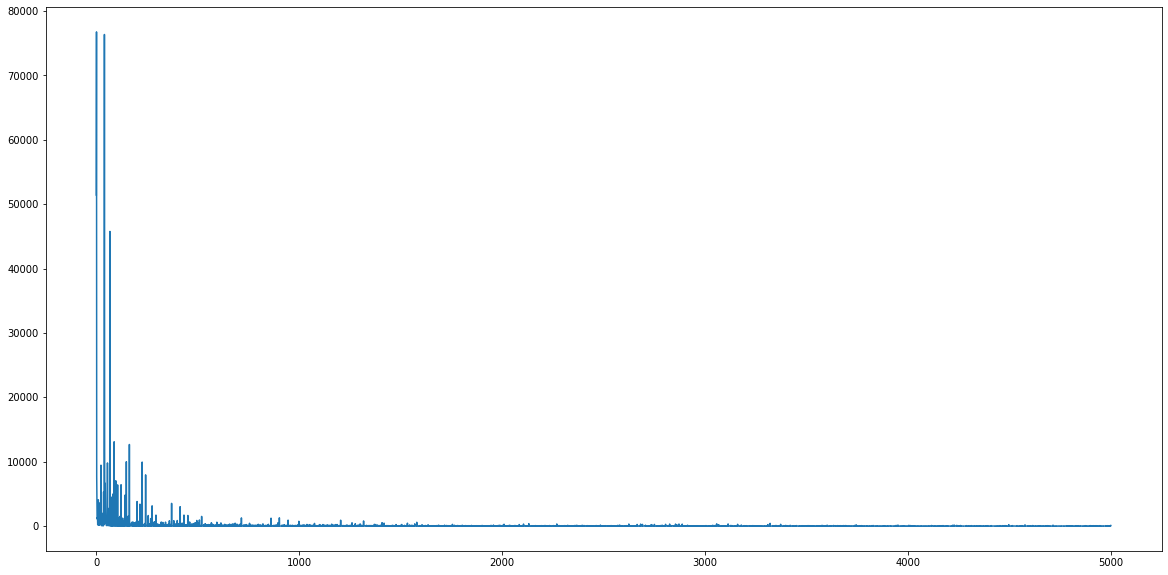

    model_path=/sharehouse/DATA/SMART_FACTORY/ckim/model/mlp-data_up_delta3.model is saved


<Figure size 432x288 with 0 Axes>

In [25]:
training(model, train_loader)

In [26]:
model.eval()

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2048, out_features=4096, bias=True)
  (9): ReLU()
  (10): Linear(in_features=4096, out_features=8192, bias=True)
  (11): ReLU()
  (12): Linear(in_features=8192, out_features=2048, bias=True)
  (13): ReLU()
  (14): Linear(in_features=2048, out_features=512, bias=True)
  (15): ReLU()
  (16): Linear(in_features=512, out_features=32, bias=True)
  (17): ReLU()
  (18): Linear(in_features=32, out_features=1, bias=True)
)

In [27]:
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [28]:
testing(model, test_loader, 10.)
testing(model, test_loader, 30.)


Testing is Started 
model is loaded
3399 3399
[[195.7423095703125], [73.86593627929688], [572.281494140625], [233.81663513183594], [819.4230346679688], [119.0284423828125], [220.61973571777344], [116.2603988647461], [170.71742248535156], [240.88743591308594]]
[[197.0], [74.0], [577.0], [236.0], [830.0], [120.0], [222.0], [117.0], [172.0], [243.0]]
평균제곱근오차 5.807958669201821
결정계수 0.9997942230391913
hit ratio with error range(10.00) = 0.9697, no of errors = 103, total = 3399

Testing is Started 
model is loaded
3399 3399
[[195.7423095703125], [73.86593627929688], [572.281494140625], [233.81663513183594], [819.4230346679688], [119.0284423828125], [220.61973571777344], [116.2603988647461], [170.71742248535156], [240.88743591308594]]
[[197.0], [74.0], [577.0], [236.0], [830.0], [120.0], [222.0], [117.0], [172.0], [243.0]]
평균제곱근오차 5.807958669201821
결정계수 0.9997942230391913
hit ratio with error range(30.00) = 0.9929, no of errors = 24, total = 3399


In [32]:
testing2(model, test_loader, X2_mean, X3_mean, X4_mean, X1_d1_mean, X3_d1_mean, 10.)
testing2(model, test_loader, X2_mean, X3_mean, X4_mean, X1_d1_mean, X3_d1_mean, 30.)


Testing is Started 
model is loaded
3399 3399
평균제곱근오차 367.94777915597103
결정계수 -11.78295143489941
hit ratio with error range(10.00) = 0.0453, no of errors = 3245, total = 3399

Testing is Started 
model is loaded
3399 3399
평균제곱근오차 367.94777915597103
결정계수 -11.78295143489941
hit ratio with error range(30.00) = 0.1415, no of errors = 2918, total = 3399


In [31]:
testing3(model, test_loader, X2_mean, X3_mean, X4_mean, X1_d1_mean, X3_d1_mean, 10.)
testing3(model, test_loader, X2_mean, X3_mean, X4_mean, X1_d1_mean, X3_d1_mean, 30.)


Testing is Started 
model is loaded
3399 3399
평균제곱근오차 388.0922968635522
결정계수 -13.251758335746873
hit ratio with error range(10.00) = 0.1792, no of errors = 2790, total = 3399

Testing is Started 
model is loaded
3399 3399
평균제곱근오차 388.0922968635522
결정계수 -13.251758335746873
hit ratio with error range(30.00) = 0.3936, no of errors = 2061, total = 3399


In [ ]:
ran = [200, 400, 600, 800, 1000]
for i in ran:
    print(i, x_test[i], y_test[i])
    print(i-1, x_test[i-1], y_test[i-1])
    print('    mean = ', x_test[i-5:i].mean(axis=0))
print()


Sample test

In [ ]:
X1_val = 169.
X2_val = 5.
X3_val = 13.
X4_val = 10.
Y0_val = 197.
X1_d1_val = 101.
X3_d1_val = 93.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
X1_d2_val = X1_d2_mean
X3_d2_val = X3_d2_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val, X1_d2_val, X3_d2_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])
X2_val = 5
X3_val = 18
X4_val = 10
X1_d1_val = 89
X3_d1_val = 18
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

In [39]:
X1_val = 29.
X2_val = 5.
X3_val = 28.
X4_val = 10.
Y0_val = 72.
X1_d1_val = 154.
X1_d2_val = 29.
X3_d1_val = 12.
X3_d2_val = 28.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 375.
X4_val = 10.
X1_d1_val = 48.
X3_d1_val = 57
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=29.00, X2=5.00, X3=28.00, X4=10.00, Y0=72.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [40]:
X1_val = 117.
X2_val = 5.
X3_val = 126.
X4_val = 10.
Y0_val = 258.
X1_d1_val = 76.
X3_d1_val = 17.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 105.
X4_val = 10.
X1_d1_val = 122.
X1_d2_val = 66.
X3_d1_val = 85.
X3_d2_val = 9.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=117.00, X2=5.00, X3=126.00, X4=10.00, Y0=258.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [41]:
X1_val = 95.
X2_val = 5.
X3_val = 6.
X4_val = 10.
Y0_val = 116.
X1_d1_val = 175.
X3_d1_val = 11.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val, X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 17.
X4_val = 10.
X1_d1_val = 167.
X3_d1_val = 17.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=95.00, X2=5.00, X3=6.00, X4=10.00, Y0=116.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [42]:
X1_val = 152.
X2_val = 5.
X3_val = 55.
X4_val = 10.
Y0_val = 222.
X1_d1_val = 282.
X3_d1_val = 259.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 55.
X4_val = 10.
X1_d1_val = 382.
X3_d1_val = 359.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=152.00, X2=5.00, X3=55.00, X4=10.00, Y0=222.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)